# RAG system with SEAT4-1, mxbai

In [1]:
# major changes from rag1-4-2
#  num_step_in_epoch
#  designate dataset name before training (since all datasets are too big)
#  how layer norms are put

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [1]:
!pip install datasets
!pip install transformers
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

## Collect Datasets

In [2]:
# Here, making database for each dataset

In [2]:
import os

directory_name = 'data'
os.makedirs(directory_name)

In [3]:
# initialization
import json
dataset_names = []

with open("dataset_names.json","w") as json_file:
    json.dump(dataset_names, json_file)


### squad

In [4]:
from datasets import load_dataset

dataset_name = "squad"

with open("dataset_names.json") as json_file:
    dataset_names = json.load(json_file)
    
if not dataset_name in dataset_names:
    dataset_names.append(dataset_name)
    with open("dataset_names.json","w") as json_file:
        json.dump(dataset_names, json_file)

dataset=load_dataset("squad")
dataset

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [5]:
import pandas as pd
dataframes = [dataset[split].to_pandas() for split in dataset.keys()]
df = pd.concat(dataframes)
df = df.drop(columns=['id', 'title', 'answers'])
df = df.rename(columns={'context': 'inf', 'question':'q'})

del dataset, dataframes

df

,inf,q
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...
...,...,...
10565,"The pound-force has a metric counterpart, less...",What is the metric term less used than the New...
10566,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...
10567,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...
10568,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...


In [6]:

import torch
import json

# make and save q_id, inf_id for making inf_one_zero in training
df["q_id"] = df.groupby('q').ngroup()
df["inf_id"] = df.groupby('inf').ngroup()

max_q_id = df['q_id'].max()
max_inf_id = df['inf_id'].max()

print("max_q_id:", int(max_q_id), "  max_inf_id:", int(max_inf_id))

meta_data = {"max_q_id":int(max_q_id), "max_inf_id":int(max_inf_id)}
with open("data/"+dataset_name+"_meta_data.json","w") as json_file:
    json.dump(meta_data, json_file)

torch.save(torch.tensor(df["q_id"].values), "./data/"+dataset_name+"_q_id.pt")
torch.save(torch.tensor(df["inf_id"].values), "./data/"+dataset_name+"_inf_id.pt")

print("meta_data was saved")

# save q and inf
import json

q_list = df.groupby('q_id').sample(n=1)["q"].to_list()
inf_list = df.groupby('inf_id').sample(n=1)["inf"].to_list()

with open("data/"+dataset_name+"_q_list.json","w") as json_file:
    json.dump(q_list, json_file)

with open("data/"+dataset_name+"_inf_list.json","w") as json_file:
    json.dump(inf_list, json_file)

print("q_list and inf_list were saved")

max_q_id: 97887   max_inf_id: 20957
meta_data was saved
q_list and inf_list were saved


#### old

In [4]:
df['id'] = df.groupby('context').ngroup()
df

,id,title,context,question,answers
0,1844,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,1844,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,1844,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,1844,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,1844,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...
...,...,...,...,...,...
10565,18215,Force,"The pound-force has a metric counterpart, less...",What is the metric term less used than the New...,"{'text': ['kilogram-force', 'pound-force', 'ki..."
10566,18215,Force,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,"{'text': ['kilopond', 'kilopond', 'kilopond', ..."
10567,18215,Force,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,"{'text': ['slug', 'metric slug', 'metric slug'..."
10568,18215,Force,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,"{'text': ['kip', 'kip', 'kip', 'kip', 'kip'], ..."


In [5]:
# id列の最大値を見つける
max_id = df['id'].max()

print(max_id)

20957


In [6]:
# 各idグループからランダムに1つの行を選択
select_df = df.groupby('id').sample(n=1)

select_df

,id,title,context,question,answers
8454,0,2008_Summer_Olympics_torch_relay,"\n Australia: The event was held in Canberra, ...",How many kilometers was the route in Australia?,"{'text': ['16'], 'answer_start': [106]}"
8218,1,2008_Summer_Olympics_torch_relay,"\n China: In China, the torch was first welcom...",Who was the biggest shareholder of Carrefour?,"{'text': ['the LVMH Group'], 'answer_start': [..."
8278,2,2008_Summer_Olympics_torch_relay,"\n France: The torch relay leg in Paris, held ...",How many times was the torch put out in France...,"{'text': ['five'], 'answer_start': [1343]}"
8260,3,2008_Summer_Olympics_torch_relay,\n Great Britain: The torch relay leg held in ...,What word was used by London officials to desc...,"{'text': ['thugs'], 'answer_start': [830]}"
8392,4,2008_Summer_Olympics_torch_relay,\n India: Due to concerns about pro-Tibet prot...,Where did the torch relay happen in India?,"{'text': ['New Delhi'], 'answer_start': [69]}"
...,...,...,...,...,...
6423,20953,Buddhism,Śuddhodana was determined to see his son becom...,What are the four sights in Buddhism?,"{'text': ['encountering an old man, a sick man..."
6706,20954,Buddhism,Śīla (Sanskrit) or sīla (Pāli) is usually tran...,What is an action committed through the body a...,"{'text': ['Śīla'], 'answer_start': [0]}"
6709,20955,Buddhism,Śīla is the foundation of Samādhi/Bhāvana (Med...,What is the foundation of Samadhi/Bhavana?,"{'text': ['Śīla'], 'answer_start': [0]}"
6711,20956,Buddhism,Śīla refers to overall principles of ethical b...,What does sila refer to?,{'text': ['overall principles of ethical behav...


In [7]:
select_df.to_csv('select_df_squad.csv', index=False)

In [8]:
import pandas as pd
select_df = pd.read_csv('select_df_squad.csv')
select_df

,id,title,context,question,answers
0,0,2008_Summer_Olympics_torch_relay,"\n Australia: The event was held in Canberra, ...",How many kilometers was the route in Australia?,"{'text': array(['16'], dtype=object), 'answer_..."
1,1,2008_Summer_Olympics_torch_relay,"\n China: In China, the torch was first welcom...",Who was the biggest shareholder of Carrefour?,"{'text': array(['the LVMH Group'], dtype=objec..."
2,2,2008_Summer_Olympics_torch_relay,"\n France: The torch relay leg in Paris, held ...",How many times was the torch put out in France...,"{'text': array(['five'], dtype=object), 'answe..."
3,3,2008_Summer_Olympics_torch_relay,\n Great Britain: The torch relay leg held in ...,What word was used by London officials to desc...,"{'text': array(['thugs'], dtype=object), 'answ..."
4,4,2008_Summer_Olympics_torch_relay,\n India: Due to concerns about pro-Tibet prot...,Where did the torch relay happen in India?,"{'text': array(['New Delhi'], dtype=object), '..."
...,...,...,...,...,...
20953,20953,Buddhism,Śuddhodana was determined to see his son becom...,What are the four sights in Buddhism?,"{'text': array(['encountering an old man, a si..."
20954,20954,Buddhism,Śīla (Sanskrit) or sīla (Pāli) is usually tran...,What is an action committed through the body a...,"{'text': array(['Śīla'], dtype=object), 'answe..."
20955,20955,Buddhism,Śīla is the foundation of Samādhi/Bhāvana (Med...,What is the foundation of Samadhi/Bhavana?,"{'text': array(['Śīla'], dtype=object), 'answe..."
20956,20956,Buddhism,Śīla refers to overall principles of ethical b...,What does sila refer to?,{'text': array(['overall principles of ethical...


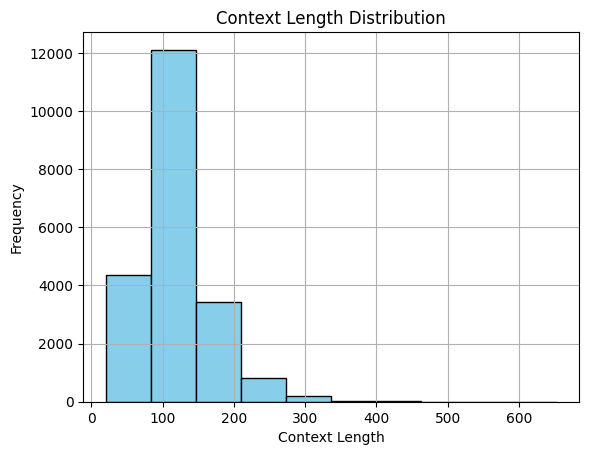

In [9]:
import matplotlib.pyplot as plt
select_df['context_length'] = select_df['context'].apply(len)
select_df['word_count'] = select_df['context'].apply(lambda x: len(x.split()))

# ヒストグラムでテキストの長さの分布を可視化
plt.hist(select_df['word_count'], bins=10, color='skyblue', edgecolor='black')
plt.title('Context Length Distribution')
plt.xlabel('Context Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


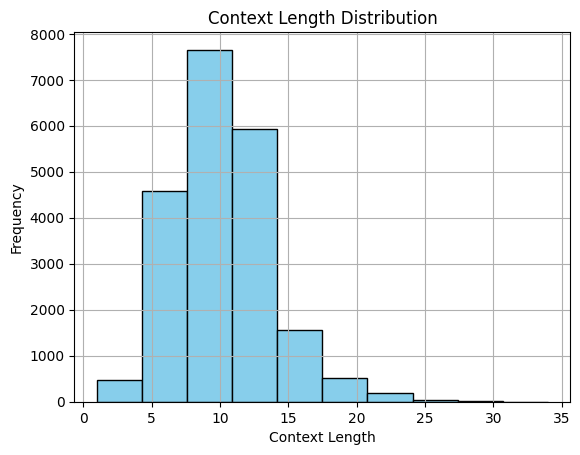

In [10]:
import matplotlib.pyplot as plt
select_df['question_length'] = select_df['question'].apply(len)
select_df['word_count'] = select_df['question'].apply(lambda x: len(x.split()))

# ヒストグラムでテキストの長さの分布を可視化
plt.hist(select_df['word_count'], bins=10, color='skyblue', edgecolor='black')
plt.title('Context Length Distribution')
plt.xlabel('Context Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### mteb/arguana

In [7]:
from datasets import load_dataset

dataset_name = "mteb_arguana"

with open("dataset_names.json") as json_file:
    dataset_names = json.load(json_file)
    
if not dataset_name in dataset_names:
    dataset_names.append(dataset_name)
    with open("dataset_names.json","w") as json_file:
        json.dump(dataset_names, json_file)

dataset=load_dataset("mteb/arguana","corpus")
dataset

Generating corpus split:   0%|          | 0/8674 [00:00<?, ? examples/s]

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 8674
    })
})

In [8]:
import pandas as pd
dataframes = [dataset[split].to_pandas() for split in dataset.keys()]
df = pd.concat(dataframes)
df = df.drop(columns=['_id'])
df = df.rename(columns={'title': 'q', 'text':'inf'})

del dataset, dataframes

df

,q,inf
0,animals environment general health health gene...,You don’t have to be vegetarian to be green. M...
1,animals environment general health health gene...,Being vegetarian helps the environment Becomi...
2,animals environment general health health gene...,"The key to good health is a balanced diet, not..."
3,animals environment general health health gene...,It is immoral to kill animals As evolved huma...
4,animals environment general health health gene...,There is a great moral difference between huma...
...,...,...
8669,,Stories about ridiculous administration costs ...
8670,,We need to address the causes of poverty rathe...
8671,,Sponsorship is often more about the intentions...
8672,,Sponsorship is an inefficient way of giving to...


In [9]:
# this shit dataset is lack of title column in many rows
# => need to exclude all of them

df = df[df["q"] != ""]
df = df[df["inf"] != ""]
df

,q,inf
0,animals environment general health health gene...,You don’t have to be vegetarian to be green. M...
1,animals environment general health health gene...,Being vegetarian helps the environment Becomi...
2,animals environment general health health gene...,"The key to good health is a balanced diet, not..."
3,animals environment general health health gene...,It is immoral to kill animals As evolved huma...
4,animals environment general health health gene...,There is a great moral difference between huma...
...,...,...
2694,economic policy society immigration house beli...,The principle at the heart of this debate is t...
2695,economic policy society immigration house beli...,This kind of argument underestimates the capac...
2696,economic policy society immigration house beli...,Freedom of movement is not an intrinsic human ...
2697,economic policy society immigration house beli...,"While factually true for developed nations, th..."


In [10]:

import torch
import json

# make and save q_id, inf_id for making inf_one_zero in training
df["q_id"] = df.groupby('q').ngroup()
df["inf_id"] = df.groupby('inf').ngroup()

max_q_id = df['q_id'].max()
max_inf_id = df['inf_id'].max()

meta_data = {"max_q_id":int(max_q_id), "max_inf_id":int(max_inf_id)}
with open("data/"+dataset_name+"_meta_data.json","w") as json_file:
    json.dump(meta_data, json_file)

torch.save(torch.tensor(df["q_id"].values), "./data/"+dataset_name+"_q_id.pt")
torch.save(torch.tensor(df["inf_id"].values), "./data/"+dataset_name+"_inf_id.pt")


# save q and inf
import json

q_list = df.groupby('q_id').sample(n=1)["q"].to_list()
inf_list = df.groupby('inf_id').sample(n=1)["inf"].to_list()

with open("data/"+dataset_name+"_q_list.json","w") as json_file:
    json.dump(q_list, json_file)

with open("data/"+dataset_name+"_inf_list.json","w") as json_file:
    json.dump(inf_list, json_file)

print("save finished")

save finished


### mteb/climate-fever

In [11]:
from datasets import load_dataset
import json

dataset_name = "mteb_climate_fever"

with open("dataset_names.json") as json_file:
    dataset_names = json.load(json_file)
    
if not dataset_name in dataset_names:
    dataset_names.append(dataset_name)
    with open("dataset_names.json","w") as json_file:
        json.dump(dataset_names, json_file)

dataset=load_dataset("mteb/climate-fever","corpus")
dataset

Generating corpus split:   0%|          | 0/5416593 [00:00<?, ? examples/s]

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 5416593
    })
})

In [12]:
import pandas as pd
dataframes = [dataset[split].to_pandas() for split in dataset.keys()]
df = pd.concat(dataframes)
df = df.drop(columns=['_id'])
df = df.rename(columns={'title': 'q', 'text':'inf'})

del dataset, dataframes

df = df[df["q"] != ""]
df = df[df["inf"] != ""]

df

,q,inf
0,1928 in association football,The following are the football ( soccer ) even...
1,1986 NBA Finals,The 1986 NBA Finals was the championship round...
2,1901 Villanova Wildcats football team,The 1901 Villanova Wildcats football team repr...
3,1992 Northwestern Wildcats football team,The 1992 Northwestern Wildcats team represente...
4,1897 Princeton Tigers football team,The 1897 Princeton Tigers football team repres...
...,...,...
5416588,Spanish flu,"The Spanish flu, also known as the 1918 flu pa..."
5416589,Avoiding Dangerous Climate Change (2005 confer...,"In 2005, an international conference titled Av..."
5416590,Indo-Aryan migration,The Indo-Aryan migrations were the migrations ...
5416591,Coral in non-tropical regions,The poleward migration of coral species refers...


In [13]:
# if number of rows in the dataset is ~ 1M, cpu memory is 
# not enought to allocate inf_one_zero and batch size is needed.
batch_size = 20000
dataset_names.remove(dataset_name)
num_batch = 0

import torch
import json

for i in range(0, len(df), batch_size):
    print(f"---- batch {num_batch} ----")
    dataset_names.append(dataset_name+str(num_batch))

    batch_df = df.iloc[i:i+batch_size]
    
    # make and save inf_one_zero
    batch_df["q_id"] = batch_df.groupby('q').ngroup()
    batch_df["inf_id"] = batch_df.groupby('inf').ngroup()
    
    max_q_id = batch_df['q_id'].max()
    max_inf_id = batch_df['inf_id'].max()

    meta_data = {"max_q_id":int(max_q_id), "max_inf_id":int(max_inf_id)}
    with open("data/"+dataset_name+str(num_batch)+"_meta_data.json","w") as json_file:
        json.dump(meta_data, json_file)
    
    torch.save(torch.tensor(batch_df["q_id"].values), "./data/"+dataset_name+str(num_batch)+"_q_id.pt")
    torch.save(torch.tensor(batch_df["inf_id"].values), "./data/"+dataset_name+str(num_batch)+"_inf_id.pt")

    
    # save q and inf   
    q_list = batch_df.groupby('q_id').sample(n=1)["q"].to_list()
    inf_list = batch_df.groupby('inf_id').sample(n=1)["inf"].to_list()
    
    with open("data/"+dataset_name+str(num_batch)+"_q_list.json","w") as json_file:
        json.dump(q_list, json_file)
    
    with open("data/"+dataset_name+str(num_batch)+"_inf_list.json","w") as json_file:
        json.dump(inf_list, json_file)

    del q_list,inf_list

    num_batch += 1
    print("save finished")

with open("dataset_names.json","w") as json_file:
    json.dump(dataset_names, json_file)

---- batch 0 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 1 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 2 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 3 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 4 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 5 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 6 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 7 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 8 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 9 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 10 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 11 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 12 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 13 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 14 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 15 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 16 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 17 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 18 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 19 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 20 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 21 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 22 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 23 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 24 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 25 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 26 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 27 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 28 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 29 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 30 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 31 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 32 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 33 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 34 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 35 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 36 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 37 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 38 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 39 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 40 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 41 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 42 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 43 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 44 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 45 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 46 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 47 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 48 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 49 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 50 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 51 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 52 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 53 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 54 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 55 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 56 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 57 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 58 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 59 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 60 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 61 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 62 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 63 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 64 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 65 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 66 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 67 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 68 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 69 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 70 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 71 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 72 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 73 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 74 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 75 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 76 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 77 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 78 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 79 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 80 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 81 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 82 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 83 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 84 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 85 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 86 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 87 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 88 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 89 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 90 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 91 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 92 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 93 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 94 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 95 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 96 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 97 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 98 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 99 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 100 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 101 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 102 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 103 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 104 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 105 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 106 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 107 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 108 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 109 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 110 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 111 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 112 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 113 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 114 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 115 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 116 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 117 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 118 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 119 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 120 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 121 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 122 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 123 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 124 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 125 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 126 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 127 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 128 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 129 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 130 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 131 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 132 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 133 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 134 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 135 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 136 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 137 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 138 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 139 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 140 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 141 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 142 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 143 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 144 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 145 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 146 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 147 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 148 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 149 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 150 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 151 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 152 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 153 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 154 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 155 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 156 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 157 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 158 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 159 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 160 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 161 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 162 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 163 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 164 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 165 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 166 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 167 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 168 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 169 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 170 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 171 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 172 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 173 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 174 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 175 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 176 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 177 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 178 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 179 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 180 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 181 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 182 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 183 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 184 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 185 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 186 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 187 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 188 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 189 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 190 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 191 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 192 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 193 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 194 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 195 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 196 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 197 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 198 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 199 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 200 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 201 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 202 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 203 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 204 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 205 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 206 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 207 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 208 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 209 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 210 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 211 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 212 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 213 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 214 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 215 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 216 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 217 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 218 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 219 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 220 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 221 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 222 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 223 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 224 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 225 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 226 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 227 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 228 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 229 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 230 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 231 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 232 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 233 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 234 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 235 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 236 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 237 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 238 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 239 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 240 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 241 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 242 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 243 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 244 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 245 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 246 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 247 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 248 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 249 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 250 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 251 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 252 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 253 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 254 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 255 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 256 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 257 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 258 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 259 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 260 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 261 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 262 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 263 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 264 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 265 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 266 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 267 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 268 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 269 ----


/tmp/ipykernel_237/2230873054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_237/2230873054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished


### mteb/dbpedia

In [12]:
from datasets import load_dataset

dataset_name = "mteb_dbpedia"

with open("dataset_names.json") as json_file:
    dataset_names = json.load(json_file)
    
if not dataset_name in dataset_names:
    dataset_names.append(dataset_name)
    with open("dataset_names.json","w") as json_file:
        json.dump(dataset_names, json_file)

dataset=load_dataset("mteb/dbpedia","corpus")
dataset

Generating corpus split:   0%|          | 0/4635922 [00:00<?, ? examples/s]

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 4635922
    })
})

In [13]:
import pandas as pd
dataframes = [dataset[split].to_pandas() for split in dataset.keys()]
df = pd.concat(dataframes)
df = df.drop(columns=['_id'])
df = df.rename(columns={'title': 'q', 'text':'inf'})

del dataset, dataframes

df = df[df["q"] != ""]
df = df[df["inf"] != ""]

df

,q,inf
0,Animalia (book),Animalia is an illustrated children's book by ...
1,Academy Award for Best Production Design,The Academy Awards are the oldest awards cerem...
2,An American in Paris,An American in Paris is a jazz-influenced symp...
3,Astronomer,An astronomer is a scientist in the field of a...
4,Answer,"Generally, an answer is a reply to a question."
...,...,...
4635917,Jimmy Benefield,James Patrick Benefield (born 6 May 1983 in Br...
4635918,Introduction to the mathematics of general rel...,The mathematics of general relativity are comp...
4635919,Kilchoman distillery,The Kilchoman distillery (pronounced Kil-ho-ma...
4635920,Something to Answer For,Something to Answer For (1969) is a novel by t...


In [14]:
# if number of rows in the dataset is ~ 1M, cpu memory is 
# not enought to allocate inf_one_zero and batch size is needed.
batch_size = 20000
dataset_names.remove(dataset_name)
num_batch = 0

import torch
import json

for i in range(0, len(df), batch_size):
    print(f"---- batch {num_batch} ----")
    dataset_names.append(dataset_name+str(num_batch))

    batch_df = df.iloc[i:i+batch_size]
    
    # make and save inf_one_zero
    batch_df["q_id"] = batch_df.groupby('q').ngroup()
    batch_df["inf_id"] = batch_df.groupby('inf').ngroup()
    
    max_q_id = batch_df['q_id'].max()
    max_inf_id = batch_df['inf_id'].max()

    meta_data = {"max_q_id":int(max_q_id), "max_inf_id":int(max_inf_id)}
    with open("data/"+dataset_name+str(num_batch)+"_meta_data.json","w") as json_file:
        json.dump(meta_data, json_file)
    
    torch.save(torch.tensor(batch_df["q_id"].values), "./data/"+dataset_name+str(num_batch)+"_q_id.pt")
    torch.save(torch.tensor(batch_df["inf_id"].values), "./data/"+dataset_name+str(num_batch)+"_inf_id.pt")

    
    # save q and inf   
    q_list = batch_df.groupby('q_id').sample(n=1)["q"].to_list()
    inf_list = batch_df.groupby('inf_id').sample(n=1)["inf"].to_list()
    
    with open("data/"+dataset_name+str(num_batch)+"_q_list.json","w") as json_file:
        json.dump(q_list, json_file)
    
    with open("data/"+dataset_name+str(num_batch)+"_inf_list.json","w") as json_file:
        json.dump(inf_list, json_file)

    del q_list,inf_list

    num_batch += 1
    print("save finished")

with open("dataset_names.json","w") as json_file:
    json.dump(dataset_names, json_file)

---- batch 0 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 1 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 2 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 3 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 4 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 5 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 6 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 7 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 8 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 9 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 10 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 11 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 12 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 13 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 14 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 15 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 16 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 17 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 18 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 19 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 20 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 21 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 22 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 23 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 24 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 25 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 26 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 27 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 28 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 29 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 30 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 31 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 32 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 33 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 34 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 35 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 36 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 37 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 38 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 39 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 40 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 41 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 42 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 43 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 44 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 45 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 46 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished


### mteb/hotpot

In [15]:
from datasets import load_dataset

dataset_name = "mteb_hotpotqa"
dataset_names.append(dataset_name)

dataset=load_dataset("mteb/hotpotqa","corpus")
dataset

Generating corpus split:   0%|          | 0/5233329 [00:00<?, ? examples/s]

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 5233329
    })
})

In [16]:
import pandas as pd
dataframes = [dataset[split].to_pandas() for split in dataset.keys()]
df = pd.concat(dataframes)
df = df.drop(columns=['_id'])
df = df.rename(columns={'title': 'q', 'text':'inf'})

del dataset, dataframes

df = df[df["q"] != ""]
df = df[df["inf"] != ""]

df

,q,inf
0,Anarchism,Anarchism is a political philosophy that advoc...
1,Autism,Autism is a neurodevelopmental disorder charac...
2,Albedo,Albedo ( ) is a measure for reflectance or opt...
3,A,"A (named , plural ""As"", ""A's"", ""a""s, ""a's"" or ..."
4,Alabama,Alabama ( ) is a state in the southeastern reg...
...,...,...
5233324,2017 ATM FA season,The 2017 season of Malaysian Armed Forces Foot...
5233325,Philip MacDonald (athlete),Philip MacDonald (1904 – 4 January 1978) was a...
5233326,Hannah T. King,Hannah T. King (16 March 1808 - 25 September 1...
5233327,Pierre Arnaudin,Pierre Arnaudin (13 June 1896 – 14 December 19...


In [17]:
# if number of rows in the dataset is ~ 1M, cpu memory is 
# not enought to allocate inf_one_zero and batch size is needed.
batch_size = 100000
dataset_names.remove(dataset_name)
num_batch = 0

import torch
import json

for i in range(0, len(df), batch_size):
    print(f"---- batch {num_batch} ----")
    dataset_names.append(dataset_name+str(num_batch))

    batch_df = df.iloc[i:i+batch_size]
    
    # make and save inf_one_zero
    batch_df["q_id"] = batch_df.groupby('q').ngroup()
    batch_df["inf_id"] = batch_df.groupby('inf').ngroup()
    
    max_q_id = batch_df['q_id'].max()
    max_inf_id = batch_df['inf_id'].max()

    meta_data = {"max_q_id":int(max_q_id), "max_inf_id":int(max_inf_id)}
    with open("data/"+dataset_name+str(num_batch)+"_meta_data.json","w") as json_file:
        json.dump(meta_data, json_file)
    
    torch.save(torch.tensor(batch_df["q_id"].values), "./data/"+dataset_name+str(num_batch)+"_q_id.pt")
    torch.save(torch.tensor(batch_df["inf_id"].values), "./data/"+dataset_name+str(num_batch)+"_inf_id.pt")

    
    # save q and inf   
    q_list = batch_df.groupby('q_id').sample(n=1)["q"].to_list()
    inf_list = batch_df.groupby('inf_id').sample(n=1)["inf"].to_list()
    
    with open("data/"+dataset_name+str(num_batch)+"_q_list.json","w") as json_file:
        json.dump(q_list, json_file)
    
    with open("data/"+dataset_name+str(num_batch)+"_inf_list.json","w") as json_file:
        json.dump(inf_list, json_file)

    del q_list,inf_list

    num_batch += 1
    print("save finished")

with open("dataset_names.json","w") as json_file:
    json.dump(dataset_names, json_file)

---- batch 0 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 1 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 2 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 3 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 4 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 5 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 6 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 7 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 8 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 9 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 10 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 11 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 12 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 13 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 14 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 15 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 16 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 17 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 18 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 19 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 20 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 21 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 22 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 23 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 24 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 25 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 26 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 27 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 28 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 29 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 30 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 31 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 32 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 33 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 34 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 35 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 36 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 37 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 38 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 39 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 40 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 41 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 42 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 43 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 44 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 45 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 46 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 47 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 48 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 49 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 50 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 51 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished
---- batch 52 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished


### mteb/nfcorpus

In [18]:
from datasets import load_dataset

dataset_name = "mteb_nfcorpus"
dataset_names.append(dataset_name)

dataset=load_dataset("mteb/nfcorpus","corpus")
dataset

Generating corpus split:   0%|          | 0/3633 [00:00<?, ? examples/s]

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 3633
    })
})

In [19]:
import pandas as pd
dataframes = [dataset[split].to_pandas() for split in dataset.keys()]
df = pd.concat(dataframes)
df = df.drop(columns=['_id'])
df = df.rename(columns={'title': 'q', 'text':'inf'})

del dataset, dataframes

df = df[df["q"] != ""]
df = df[df["inf"] != ""]

df

,q,inf
0,Statin Use and Breast Cancer Survival: A Natio...,"Recent studies have suggested that statins, an..."
1,Statin use after diagnosis of breast cancer an...,BACKGROUND: Preclinical studies have shown tha...
2,Alkylphenols in human milk and their relations...,The aims of this study were to determine the c...
3,Methylmercury: A Potential Environmental Risk ...,Epilepsy or seizure disorder is one of the mos...
4,Sensitivity of Continuous Performance Test (CP...,Hit Reaction Time latencies (HRT) in the Conti...
...,...,...
3628,Effect of freezing and storage on the phenolic...,Scottish-grown red raspberries are a rich sour...
3629,Topical vitamin A treatment of recalcitrant co...,BACKGROUND: Common warts (verruca vulgaris) ar...
3630,Esophageal injury by apple cider vinegar table...,Apple cider vinegar products are advertised in...
3631,Cannabis and the lung.,The use of cannabis is embedded within many so...


In [20]:
# if number of rows in the dataset is ~ 1M, cpu memory is 
# not enought to allocate inf_one_zero and batch size is needed.
batch_size = 100000
dataset_names.remove(dataset_name)
num_batch = 0

import torch
import json

for i in range(0, len(df), batch_size):
    print(f"---- batch {num_batch} ----")
    dataset_names.append(dataset_name+str(num_batch))

    batch_df = df.iloc[i:i+batch_size]
    
    # make and save inf_one_zero
    batch_df["q_id"] = batch_df.groupby('q').ngroup()
    batch_df["inf_id"] = batch_df.groupby('inf').ngroup()
    
    max_q_id = batch_df['q_id'].max()
    max_inf_id = batch_df['inf_id'].max()

    meta_data = {"max_q_id":int(max_q_id), "max_inf_id":int(max_inf_id)}
    with open("data/"+dataset_name+str(num_batch)+"_meta_data.json","w") as json_file:
        json.dump(meta_data, json_file)
    
    torch.save(torch.tensor(batch_df["q_id"].values), "./data/"+dataset_name+str(num_batch)+"_q_id.pt")
    torch.save(torch.tensor(batch_df["inf_id"].values), "./data/"+dataset_name+str(num_batch)+"_inf_id.pt")

    
    # save q and inf   
    q_list = batch_df.groupby('q_id').sample(n=1)["q"].to_list()
    inf_list = batch_df.groupby('inf_id').sample(n=1)["inf"].to_list()
    
    with open("data/"+dataset_name+str(num_batch)+"_q_list.json","w") as json_file:
        json.dump(q_list, json_file)
    
    with open("data/"+dataset_name+str(num_batch)+"_inf_list.json","w") as json_file:
        json.dump(inf_list, json_file)

    del q_list,inf_list

    num_batch += 1
    print("save finished")

with open("dataset_names.json","w") as json_file:
    json.dump(dataset_names, json_file)

---- batch 0 ----


/tmp/ipykernel_3503/2902152723.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["q_id"] = batch_df.groupby('q').ngroup()
/tmp/ipykernel_3503/2902152723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df["inf_id"] = batch_df.groupby('inf').ngroup()


save finished


### From jsonl file (old)

In [ ]:
import json
import pandas as pd

# Specify the path to your JSONL file
jsonl_file_path = './data/nfcorpus_corpus.jsonl'

dataset_name = "mteb_nfcorpus"
dataset_names.append(dataset_name)

title_list = []
text_list = []

with open(jsonl_file_path, 'r') as jsonl_file:
    for line in jsonl_file:
        # json.loads(line) : dict
        title_list.append(json.loads(line)["title"])
        text_list.append(json.loads(line)["text"])

df = pd.DataFrame()
df["q"] = title_list
df["inf"] = text_list

df = df[df["q"] != ""]
df = df[df["inf"] != ""]

df

### Merge (old)

In [6]:
df["q_id"] = df.groupby('q').ngroup()
df["inf_id"] = df.groupby('inf').ngroup()
df

,inf,q,q_id,inf_id
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,28895,2059
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,47742,2059
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,25945,2059
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,48942,2059
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,60543,2059
...,...,...,...,...
2694,The principle at the heart of this debate is t...,economic policy society immigration house beli...,97404,20315
2695,This kind of argument underestimates the capac...,economic policy society immigration house beli...,97404,21685
2696,Freedom of movement is not an intrinsic human ...,economic policy society immigration house beli...,97404,6048
2697,"While factually true for developed nations, th...",economic policy society immigration house beli...,97404,23002


In [7]:
max_q_id = df['q_id'].max()
max_inf_id = df['inf_id'].max()
max_q_id, max_inf_id

(98070, 23547)

In [8]:
import torch
import json

q_batch_size = 5000  # adjust based on your cpu memory (without this kernel dead will happen)
num_batch = 0

for i in range(0, max_q_id+1, q_batch_size): # max_q_id+1 because the id starts from 0
    selected_df = df.iloc[i:i+q_batch_size]
    batch_inf_one_zero = torch.zeros(len(selected_df), max_inf_id+1)
    batch_inf_one_zero[selected_df['q_id']-i, selected_df['inf_id']] = 1
    
    torch.save(batch_inf_one_zero, "./dataset/inf_one_zero"+str(num_batch)+".pt")
    num_batch += 1

    print(f"batch {num_batch} finished")


q_list = df.groupby('q_id').sample(n=1)["q"].to_list()
inf_list = df.groupby('inf_id').sample(n=1)["inf"].to_list()

with open("data/q_list.json","w") as json_file:
    json.dump(q_list, json_file)

with open("data/inf_list.json","w") as json_file:
    json.dump(inf_list, json_file)


IndexError: index 63593 is out of bounds for dimension 0 with size 5000

In [ ]:
# it's weired that number of rows in df and number of 1 in inf_one_zero
# are different. Some of the ids are overcounted although it was already grouped.

In [34]:
df.groupby('inf_id').sample(n=1)

,q,inf,q_id,inf_id
248,ational africa sport team sports house support...,"2006 was a while ago, at a time when quotas we...",18,0
65,climate house believes were too late global cl...,450 PPM The IPCC's Fourth Assessment Report d...,32,1
839,global house believes united nations has failed,": Main purpose of UN, to prevent war, has clea...",83,2
1114,europe global human rights house believes euro...,A Ban that is not very effective is better tha...,72,3
1104,ic policy eurozone crisis finance internationa...,A Greek default would have a negative domino-e...,102,4
...,...,...,...,...
355,y free speech debate free know house believes ...,‘Separation of town and gown’ There are two p...,180,2585
2352,e internet freedom politics government digital...,‘Spying on the internet’ is nothing different ...,53,2586
594,economic policy tax politics government house ...,"“After three years, it is clear that President...",58,2587
1365,ights punishment philosophy ethics life house ...,“Benefits” of capital punishment apply univers...,103,2588


In [33]:
q_list = df.groupby('q_id').sample(n=1)["q"].to_list()
inf_list = df.groupby('inf_id').sample(n=1)["inf"].to_list()

#### test

In [10]:
import requests
from bs4 import BeautifulSoup
import os

# URL of the page containing the link to the file
url = 'https://huggingface.co/datasets/mteb/arguana/blob/main/corpus.jsonl'

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find the link to the file
file_link = soup.find('a', href=True)['href']

# Download the file
file_response = requests.get(file_link)

# Specify the path to save the downloaded file
file_name = os.path.basename(file_link)
save_path = './data/' + file_name

# Save the file to the specified path
with open(save_path, 'wb') as file:
    file.write(file_response.content)

print("File downloaded successfully.")


MissingSchema: Invalid URL '/': No scheme supplied. Perhaps you meant https:///?

In [8]:
import requests

url = 'https://huggingface.co/datasets/mteb/arguana/blob/main/corpus.jsonl'
destination_path = './data/arguana_corpus.jsonl'

response = requests.get(url)
with open(destination_path, 'wb') as file:
    file.write(response.content)

In [5]:
import urllib.request

url = 'https://huggingface.co/datasets/mteb/arguana/blob/main/corpus.jsonl'
destination_path = './data/arguana_corpus.jsonl'
urllib.request.urlretrieve(url, destination_path)

('./data/arguana_corpus.jsonl', <http.client.HTTPMessage at 0x7f7487f1ead0>)

In [9]:
import json
import pandas as pd

# Specify the path to your JSONL file
jsonl_file_path = './data/arguana_corpus.jsonl'

title_list = []
text_list = []

with open(jsonl_file_path, 'r') as jsonl_file:
    for line in jsonl_file:
        # json.loads(line) : dict
        title_list.append(json.loads(line)["title"])
        text_list.append(json.loads(line)["text"])

df = pd.DataFrame()
df["q"] = title_list
df["inf"] = text_list
df

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [3]:
# this doesn't work
from datasets import load_dataset

dataset=load_dataset("mteb/arguana")
dataset

Generating test split:   0%|          | 0/1406 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['query-id', 'corpus-id', 'score'],
        num_rows: 1406
    })
})

## Embedding dataset (for training SEAT)

### Embedding

In [11]:
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/112k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

#### without preprocessing context

In [12]:
# tokenizerにpandas dataframeを入れてtorch.tensorがしっかり帰ってくるようならば以下のcodeで処理できる
import torch

device = "cuda" if torch.cuda.is_available else "cpu"
model.to(device)

def save_outputs(text_series, batch_size, file_path):
    num_batch = 0
    all_outputs = torch.tensor([])

    for i in range(0, len(text_series), batch_size):
        batch_text_series = text_series[i:i+batch_size]
        
        print("i:",i," preprocess finished")

        # Get model outputs
        with torch.no_grad():
            outputs = torch.tensor(model.encode(batch_text_series))

            print("encoding finished")
            all_outputs = torch.cat((all_outputs, outputs.detach().cpu()), dim=0)
            
            num_batch += 1

            del outputs
        
        print(100*(i+batch_size)/len(text_series), "% finished")

    torch.save(all_outputs, file_path+".pt")


q_batch_size = 20000
inf_batch_size = 1000

import json
with open("dataset_names.json") as json_file:
    dataset_names = json.load(json_file)

train_ratio = 0.9

for name in dataset_names:
    with open("data/"+name+"_q_list.json") as json_file:
        q_list = json.load(json_file)

    with open("data/"+name+"_inf_list.json") as json_file:
        inf_list = json.load(json_file)

    train_size = int(len(q_list)*train_ratio)
    
    save_outputs(q_list[:train_size], q_batch_size, "./dataset/"+name+"_mxbai_q_embs_train")
    save_outputs(q_list[train_size:], q_batch_size, "./dataset/"+name+"_mxbai_q_embs_test")
    
    # inf doesn't have train_test split
    save_outputs(inf_list, inf_batch_size, "./dataset/"+name+"_mxbai_inf_embs")



i: 0  preprocess finished
encoding finished
22.701733277335723 % finished
i: 20000  preprocess finished
encoding finished
45.403466554671446 % finished
i: 40000  preprocess finished
encoding finished
68.10519983200717 % finished
i: 60000  preprocess finished
encoding finished
90.80693310934289 % finished
i: 80000  preprocess finished
encoding finished
113.50866638667863 % finished
i: 0  preprocess finished
encoding finished
204.31096128307283 % finished
i: 0  preprocess finished
encoding finished
4.7714476572192 % finished
i: 1000  preprocess finished
encoding finished
9.5428953144384 % finished
i: 2000  preprocess finished
encoding finished
14.3143429716576 % finished
i: 3000  preprocess finished
encoding finished
19.0857906288768 % finished
i: 4000  preprocess finished
encoding finished
23.857238286096003 % finished
i: 5000  preprocess finished
encoding finished
28.6286859433152 % finished
i: 6000  preprocess finished
encoding finished
33.4001336005344 % finished
i: 7000  preprocess 

#### splitting context into sentences

In [16]:
import pandas as pd

# CSVファイルからDataFrameを読み込み（仮のファイルパスを使用しています）
select_df = pd.read_csv('select_df_squad.csv')

# 'context'列をピリオドで分割し、結果の各リストから空の文字列を除外
select_df['sentences'] = select_df['context'].str.split('\.').apply(lambda x: [sentence for sentence in x if sentence.strip()])

# 結果の確認
print(select_df['sentences'][3])
select_df

['\n Great Britain: The torch relay leg held in London, the host city of the 2012 Summer Olympics, on April 6 began at Wembley Stadium, passed through the City of London, and eventually ended at O2 Arena in the eastern part of the city', ' The 48 km (30 mi) leg took a total of seven and a half hours to complete, and attracted protests by pro-Tibetan independence and pro-Human Rights supporters, prompting changes to the planned route and an unscheduled move onto a bus, which was then briefly halted by protestors', ' Home Secretary Jacqui Smith has officially complained to Beijing Organising Committee about the conduct of the tracksuit-clad Chinese security guards', ' The Chinese officials, seen manhandling protesters, were described by both the London Mayor Ken Livingstone and Lord Coe, chairman of the London Olympic Committee as "thugs"', ' A Metropolitan police briefing paper revealed that security for the torch relay cost £750,000 and the participation of the Chinese security team ha

,id,title,context,question,answers,sentences
0,0,2008_Summer_Olympics_torch_relay,"\n Australia: The event was held in Canberra, ...",What is the name of the Aboriginal elder who r...,"{'text': array(['Agnes Shea'], dtype=object), ...","[\n Australia: The event was held in Canberra,..."
1,1,2008_Summer_Olympics_torch_relay,"\n China: In China, the torch was first welcom...",What method did the Chinese government use to ...,"{'text': array(['censorship'], dtype=object), ...","[\n China: In China, the torch was first welco..."
2,2,2008_Summer_Olympics_torch_relay,"\n France: The torch relay leg in Paris, held ...",What date did the torch relay begin in France?,"{'text': array(['April 7'], dtype=object), 'an...","[\n France: The torch relay leg in Paris, held..."
3,3,2008_Summer_Olympics_torch_relay,\n Great Britain: The torch relay leg held in ...,Where did the relay end in London?,"{'text': array(['O2 Arena'], dtype=object), 'a...",[\n Great Britain: The torch relay leg held in...
4,4,2008_Summer_Olympics_torch_relay,\n India: Due to concerns about pro-Tibet prot...,How many bearers decided not to participate?,"{'text': array(['five'], dtype=object), 'answe...",[\n India: Due to concerns about pro-Tibet pro...
...,...,...,...,...,...,...
20953,20953,Buddhism,Śuddhodana was determined to see his son becom...,What happened when Gautama left the palace gro...,{'text': array(['he learned of the suffering o...,[Śuddhodana was determined to see his son beco...
20954,20954,Buddhism,Śīla (Sanskrit) or sīla (Pāli) is usually tran...,What is an action committed through the body a...,"{'text': array(['Śīla'], dtype=object), 'answe...",[Śīla (Sanskrit) or sīla (Pāli) is usually tra...
20955,20955,Buddhism,Śīla is the foundation of Samādhi/Bhāvana (Med...,What keeps the cultivator from rebirth in the ...,"{'text': array(['keeping the precepts'], dtype...",[Śīla is the foundation of Samādhi/Bhāvana (Me...
20956,20956,Buddhism,Śīla refers to overall principles of ethical b...,What does sila refer to?,{'text': array(['overall principles of ethical...,[Śīla refers to overall principles of ethical ...


In [17]:
select_df['num_batch'] = pd.NA  # NAはPandasの欠損値です

# 各行に対して質問の数を設定
for i in range(len(select_df)):
    select_df.loc[i, 'num_batch'] = len(select_df['sentences'][i])  # .locを使って安全に値を代入
    
max_context_tokens = select_df['num_batch'].max()
max_context_tokens

45

In [18]:
# 新しい列を追加する関数（最大列数を考慮）
def extract_contexts_limited(row):
    # 辞書リストから質問を抽出し、最大列数に制限
    contexts = row['sentences'][:max_context_tokens]
    # 残りを""で埋める
    contexts += [""] * (max_context_tokens - len(contexts))
    row['sentences'] = contexts
    return row

select_df = select_df.apply(extract_contexts_limited, axis=1)

# 新しい列をDataFrameに追加（制限付き）
#contexts_columns_limited = select_df.apply(extract_contexts_limited, axis=1)
#contexts_columns_limited.columns = [f'sentence_{i+1}' for i in range(contexts)]

# 元のDataFrameに新しい列を結合
#select_df = pd.concat([select_df, contexts_columns_limited], axis=1)
#select_df.drop('sentences', axis=1, inplace=True)

# 結果の確認
select_df


,id,title,context,question,answers,sentences,num_batch
0,0,2008_Summer_Olympics_torch_relay,"\n Australia: The event was held in Canberra, ...",What is the name of the Aboriginal elder who r...,"{'text': array(['Agnes Shea'], dtype=object), ...","[\n Australia: The event was held in Canberra,...",6
1,1,2008_Summer_Olympics_torch_relay,"\n China: In China, the torch was first welcom...",What method did the Chinese government use to ...,"{'text': array(['censorship'], dtype=object), ...","[\n China: In China, the torch was first welco...",10
2,2,2008_Summer_Olympics_torch_relay,"\n France: The torch relay leg in Paris, held ...",What date did the torch relay begin in France?,"{'text': array(['April 7'], dtype=object), 'an...","[\n France: The torch relay leg in Paris, held...",14
3,3,2008_Summer_Olympics_torch_relay,\n Great Britain: The torch relay leg held in ...,Where did the relay end in London?,"{'text': array(['O2 Arena'], dtype=object), 'a...",[\n Great Britain: The torch relay leg held in...,7
4,4,2008_Summer_Olympics_torch_relay,\n India: Due to concerns about pro-Tibet prot...,How many bearers decided not to participate?,"{'text': array(['five'], dtype=object), 'answe...",[\n India: Due to concerns about pro-Tibet pro...,11
...,...,...,...,...,...,...,...
20953,20953,Buddhism,Śuddhodana was determined to see his son becom...,What happened when Gautama left the palace gro...,{'text': array(['he learned of the suffering o...,[Śuddhodana was determined to see his son beco...,4
20954,20954,Buddhism,Śīla (Sanskrit) or sīla (Pāli) is usually tran...,What is an action committed through the body a...,"{'text': array(['Śīla'], dtype=object), 'answe...",[Śīla (Sanskrit) or sīla (Pāli) is usually tra...,5
20955,20955,Buddhism,Śīla is the foundation of Samādhi/Bhāvana (Med...,What keeps the cultivator from rebirth in the ...,"{'text': array(['keeping the precepts'], dtype...",[Śīla is the foundation of Samādhi/Bhāvana (Me...,4
20956,20956,Buddhism,Śīla refers to overall principles of ethical b...,What does sila refer to?,{'text': array(['overall principles of ethical...,[Śīla refers to overall principles of ethical ...,4


In [19]:
# tokenizerにpandas dataframeを入れてtorch.tensorがしっかり帰ってくるようならば以下のcodeで処理できる
import torch

device = "cuda" if torch.cuda.is_available else "cpu"
model.to(device)

def get_cat_list(series):
    cat_list = []
    num_rows = 0
    for text_list in series:
        num_rows += 1
        cat_list += text_list
    return cat_list, num_rows

def save_outputs(text_series, batch_size, max_length, file_path):
    num_batch = 0

    for i in range(0, len(text_series), batch_size):
        batch_text_series, num_rows = get_cat_list(text_series[i:i+batch_size])
        print("i:",i," preprocess finished")
        #inputs = tokenizer(batch_text_series, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
        
        #inputs.to(device)
        
        # Get model outputs
        with torch.no_grad():
            outputs = torch.tensor(model.encode(batch_text_series))
            outputs = outputs.reshape(num_rows, max_length, -1)

            print("encoding finished")
            torch.save(outputs.detach().cpu(), file_path+str(num_batch)+".pt")
            num_batch += 1

            del outputs
        
        print(100*(i+batch_size)/len(text_series), "% finished")

#batch_size_questions = 100  # Adjust based on your GPU memory
batch_size_contexts = 20000

#max_length_questions = 10  # Set all token length same
max_length_contexts = max_context_tokens

# Adjust considering cpu memory. torch.save and torch.load takes much time,
# so output should be accumulated in cpu memory as much as possible.
# ex. total size of data is around 400GB and cpu memory is around 58GB,
# therefore, around 10% of data can be accumulated in cpu memory. 
#save_rate = 1

# here each list in select_df["sentences"] must have same length
save_outputs(select_df["sentences"], batch_size_contexts, max_length_contexts, "./Contexts/squad_contexts_split_token")




i: 0  preprocess finished
encoding finished
95.42895314438401 % finished
i: 20000  preprocess finished
encoding finished
190.85790628876802 % finished


In [20]:
def save_outputs(text_series, batch_size, max_length, file_path):
    num_batch = 0

    for i in range(0, len(text_series), batch_size):
        batch_text_series = text_series[i:i+batch_size].to_list()
        num_rows = len(batch_text_series)
        print("i:",i," preprocess finished")
        
        # Get model outputs
        with torch.no_grad():
            outputs = torch.tensor(model.encode(batch_text_series))
            outputs = outputs.reshape(num_rows, max_length, -1)

            print("encoding finished")
            torch.save(outputs.detach().cpu(), file_path+str(num_batch)+".pt")
            num_batch += 1

            del outputs
        
        print(100*(i+batch_size)/len(text_series), "% finished")

max_length_contexts = 1
batch_size_questions = 20000
save_outputs(select_df["question"], batch_size_contexts, max_length_contexts, "./Questions/squad_questions_split_token")


i: 0  preprocess finished
encoding finished
95.42895314438401 % finished
i: 20000  preprocess finished
encoding finished
190.85790628876802 % finished


### embedding test

In [11]:
import torch

model.config.output_hidden_states = True
model.config.output_attentions = False

def get_outputs(text_list, batch_size, max_length):
    all_outputs = []

    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]  # List of texts
        inputs = tokenizer(batch_texts, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
        
        inputs.to("cuda")
        model.to("cuda")
        
        # Get model outputs
        with torch.no_grad():
            outputs = model(**inputs)

            if i==0:
                for j in range(len(outputs.hidden_states)):  # loop for number of layers
                    all_outputs.append(outputs.hidden_states[j].detach().cpu())
            else:
                for j in range(len(outputs.hidden_states)):
                    print(all_outputs[j].shape, outputs.hidden_states[j].shape)
                    all_outputs[j] = torch.cat((all_outputs[j], outputs.hidden_states[j].detach().cpu()), dim=0)

            # decrease burden on GPU
            for key, value in inputs.items():
                if isinstance(value, torch.Tensor):
                    inputs[key] = value.cpu()
                    
    return all_outputs

batch_size = 32  # Adjust based on your GPU memory
max_length = 20  # Set all token length same

outputs_questions = get_outputs(select_dataset["question"][:100], batch_size, max_length)
len(outputs_questions)

torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) torch.Size([32, 20, 4096])
torch.Size([32, 20, 4096]) t

33

In [13]:
len(outputs_questions), outputs_questions[0].shape

(33, torch.Size([100, 20, 4096]))

In [ ]:
torch.save(outputs_questions, "./squad_questions_hidden_states.pt")
torch.save(outputs_contexts, "./squad_contexts_hidden_states.pt")
torch.save(outputs_answers, "./squad_answers_hidden_states.pt")

In [6]:
select_df

,id,title,context,question,answers
0,0,2008_Summer_Olympics_torch_relay,"\n Australia: The event was held in Canberra, ...",Where was the relay held in Australia?,"{'text': array(['Canberra'], dtype=object), 'a..."
1,1,2008_Summer_Olympics_torch_relay,"\n China: In China, the torch was first welcom...",Who was said to have given money to the Dalai ...,"{'text': array(['the LVMH Group'], dtype=objec..."
2,2,2008_Summer_Olympics_torch_relay,"\n France: The torch relay leg in Paris, held ...",What city in France did the torch relay start at?,"{'text': array(['Paris'], dtype=object), 'answ..."
3,3,2008_Summer_Olympics_torch_relay,\n Great Britain: The torch relay leg held in ...,Where did the torch relay begin in London for ...,"{'text': array(['Wembley Stadium'], dtype=obje..."
4,4,2008_Summer_Olympics_torch_relay,\n India: Due to concerns about pro-Tibet prot...,How many runners carried the torch in New Delhi?,"{'text': array(['70'], dtype=object), 'answer_..."
...,...,...,...,...,...
1862,1862,IPod,iTunes 7 and above can transfer purchased medi...,What minimum version of iTunes is required to ...,"{'text': array(['iTunes 7'], dtype=object), 'a..."
1863,1863,Buddhism,Śuddhodana was determined to see his son becom...,What were his first four encounters called?,"{'text': array(['the four sights'], dtype=obje..."
1864,1864,Buddhism,Śīla (Sanskrit) or sīla (Pāli) is usually tran...,Sila is the second what?,"{'text': array(['pāramitā'], dtype=object), 'a..."
1865,1865,Buddhism,Śīla is the foundation of Samādhi/Bhāvana (Med...,What promotes not only the peace of mind but a...,"{'text': array(['keeping the precepts'], dtype..."


In [4]:
import torch
from transformers import AutoTokenizer

device = "cuda" if torch.cuda.is_available else "cpu"

def tokenize(batch):
    question_inputs = tokenizer(batch['question'], padding=True, truncation=True, return_tensors="pt")["input_ids"]
    context_inputs = tokenizer(batch['context'], padding=True, truncation=True, return_tensors="pt")["input_ids"]
    answer_inputs = tokenizer(batch['answers'], padding=True, truncation=True, return_tensors="pt")["input_ids"]

    # Convert BatchEncoding to lists (or another supported format)
    #question_inputs = {k: v.tolist() for k, v in question_inputs.items()}
    #context_inputs = {k: v.tolist() for k, v in context_inputs.items()}
    #answer_inputs = {k: v.tolist() for k, v in answer_inputs.items()}

    # Prepare the result dictionary
    res = {
        "question": batch['question'],
        "context": batch['context'],
        "answers": batch["answers"],
        "question_inputs": question_inputs, # ['input_ids'],
        "context_inputs": context_inputs, #['input_ids'],
        "answer_inputs": answer_inputs #['input_ids']
    }

    # Optionally, include attention masks and token type ids if needed
    # For example:
    # res["question_attention_mask"] = question_inputs['attention_mask']
    # res["context_attention_mask"] = context_inputs['attention_mask']
    # Adjust according to your needs

    return res

# Assuming select
select_dataset = select_dataset.map(tokenize, batched = True, batch_size=None)
select_dataset

Map:   0%|          | 0/1867 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'question_inputs', 'context_inputs', 'answer_inputs'],
    num_rows: 1867
})

In [ ]:
from datasets import load_dataset
save_directory = "squad_SEAT2_2_1"
dataset.save_to_disk(save_directory)

In [16]:
from torch import nn 
from transformers import AutoConfig
config = AutoConfig.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(32000, 4096)

In [17]:
from torch.utils.data import DataLoader

context_encoded.set_format(type='torch', columns=['input_ids'])

# DataLoaderの設定。shuffle=Falseでデータセットの順番を保持
context_data_loader = DataLoader(context_encoded, batch_size=32, shuffle=False)

all_embeddings = []  # エンベディングを格納するリスト

for batch in context_data_loader:
    input_ids = batch['input_ids']
    embeddings = token_emb(input_ids)  # エンベディングを計算
    all_embeddings.append(embeddings)

# 全てのエンベディングを一つのテンソルに結合
context_input_embeds = torch.cat(all_embeddings, dim=0)
context_input_embeds.size()

torch.Size([1867, 791, 4096])

In [18]:
from torch.utils.data import DataLoader

question_encoded.set_format(type='torch', columns=['input_ids'])

# DataLoaderの設定。shuffle=Falseでデータセットの順番を保持
question_data_loader = DataLoader(question_encoded, batch_size=32, shuffle=False)

all_embeddings = []  # エンベディングを格納するリスト

for batch in question_data_loader:
    input_ids = batch['input_ids']
    embeddings = token_emb(input_ids)  # エンベディングを計算
    all_embeddings.append(embeddings)

# 全てのエンベディングを一つのテンソルに結合
question_input_embeds = torch.cat(all_embeddings, dim=0)
question_input_embeds.size()

torch.Size([1867, 43, 4096])

In [19]:
import numpy as np
context_numpy_array = context_input_embeds.cpu().detach().numpy()
question_numpy_array = question_input_embeds.cpu().detach().numpy()

np.save("./question_tensor_data.npy", question_numpy_array)
np.save("./context_tensor_data.npy", context_numpy_array)

In [26]:
def save_weight(model, layer_names):
    for name, param in model.named_parameters():
        if name in layer_names:
            print(name)
            np.save("./Mistral/" + name + ".npy", param.detach().numpy())

model.to("cpu")
layer_names = ["model.layers.0.self_attn.q_proj.weight","model.layers.0.self_attn.k_proj.weight","model.embed_tokens.weight"]
save_weight(model, layer_names)


model.embed_tokens.weight
model.layers.0.self_attn.q_proj.weight
model.layers.0.self_attn.k_proj.weight


In [22]:
def show_all_parameters(model):
    for name, param in model.named_parameters():
        print(name, " : ", param.requires_grad)

show_all_parameters(model)

model.embed_tokens.weight  :  True
model.layers.0.self_attn.q_proj.weight  :  True
model.layers.0.self_attn.k_proj.weight  :  True
model.layers.0.self_attn.v_proj.weight  :  True
model.layers.0.self_attn.o_proj.weight  :  True
model.layers.0.mlp.gate_proj.weight  :  True
model.layers.0.mlp.up_proj.weight  :  True
model.layers.0.mlp.down_proj.weight  :  True
model.layers.0.input_layernorm.weight  :  True
model.layers.0.post_attention_layernorm.weight  :  True
model.layers.1.self_attn.q_proj.weight  :  True
model.layers.1.self_attn.k_proj.weight  :  True
model.layers.1.self_attn.v_proj.weight  :  True
model.layers.1.self_attn.o_proj.weight  :  True
model.layers.1.mlp.gate_proj.weight  :  True
model.layers.1.mlp.up_proj.weight  :  True
model.layers.1.mlp.down_proj.weight  :  True
model.layers.1.input_layernorm.weight  :  True
model.layers.1.post_attention_layernorm.weight  :  True
model.layers.2.self_attn.q_proj.weight  :  True
model.layers.2.self_attn.k_proj.weight  :  True
model.layers.

In [ ]:
class AttentionHead(nn.Module):
def __init__(self, embed_dim, head_dim):
    super().__init__()
    self.q = nn.Linear(embed_dim, head_dim)
    self.k = nn.Linear(embed dim, head dim)
    self.v = nn.Linear(embed_dim, head_dim)
def forward(self, hidden_state):
    attn_outputs = scaled_dot_product_attention(self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
    return attn_outputs

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init_()
    embed_dim = config.hidden size
    num_heads = config.num_attention_heads
    head_dim = embed_dim // num_heads
    self.heads = nn.ModuleList(
    [AttentionHead (embed_dim, head dim) for _ in range(num_heads)]
    self.output_linear = nn.Linear(embed_dim, embed_dim)
        
def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self. heads], dim=-1)
        x = self.output_linear(x)
        return x

## PDF to Sentences

In [3]:
# Making use of the following site
# https://sentencesplitter.com
# document.doc file can be made up,
# and here the file is converted into
# sentences list. The sentence list is 
# saved into json file

from bs4 import BeautifulSoup
import json

with open("document.doc") as f:
    text = f.read()

# Parse the HTML content
soup = BeautifulSoup(text, 'html.parser')

# Find all <p> tags
p_tags = soup.find_all('p')

sentences = []
# Extract text from each <p> tag
for p_tag in p_tags:
    sentences.append(p_tag.text)

with open("sentences.json", "w") as f:
    json.dump(sentences, f)

print(f"number of sentences:{len(sentences)}")
print("sentences.json was made up")

sentences.json was made up


## Embedding chunks for evaluating with database

### by e5-mistral-7b-instruct

In [1]:
import torch
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel



def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

# originally this embedding model is finetuned based on these pre texts
# but ignoring it now since these work is expected to be done by SEAT4

"""
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'


# Each query must come with a one-sentence instruction that describes the task
task = 'Given a web search query, retrieve relevant passages that answer the query'
queries = [
    get_detailed_instruct(task, 'how much protein should a female eat'),
    get_detailed_instruct(task, 'summit define')
]
# No need to add instruction for retrieval documents
documents = [
    "As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
    "Definition of summit for English Language Learners. : 1  the highest point of a mountain : the top of a mountain. : 2  the highest level. : 3  a meeting or series of meetings between the leaders of two or more governments."
]
input_texts = queries + documents
"""

tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-mistral-7b-instruct')
model = AutoModel.from_pretrained('intfloat/e5-mistral-7b-instruct')



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
# make pandas dataframe
import json

json_file_path = "./chunks.json"

with open(json_file_path, 'r') as json_file:
    sentences = json.load(json_file)

import pandas as pd
df = pd.DataFrame({'chunks': sentences})
df

,chunks
0,\\documentclass[10pt]{article}\n\\usepackage[u...
1,\\section*{Preface}\nThe book of Computational...
2,Niu at Tokyo Institute of Technology guided me...
3,\\item Figures 9.33-9.35: Reprinted figures w...
4,\\section*{Contents}\n1 Introduction to Plasma...
...,...
173,\\section*{References}\n\\begin{enumerate}\n ...
174,\\section*{Appendix G \n Derivation of $\\epsi...
175,"\n\n\nHere $n$ and $m$ are integers, shows the..."
176,"section*{I}\nImplosion efficiency, 208, 211\n\..."


In [3]:
import torch

device = "cuda" if torch.cuda.is_available else "cpu"
model.to(device)

"""
def get_cat_list(series):
    cat_list = []
    num_rows = 0
    for text_list in series:
        num_rows += 1
        cat_list += text_list
    return cat_list, num_rows
"""

def save_outputs(text_series, batch_size, file_path):
    num_batch = 0
    all_outputs = torch.tensor([])

    for i in range(0, len(text_series), batch_size):
        batch_text_series = text_series[i:i+batch_size].to_list()
        num_rows = len(batch_text_series)
        #inputs = tokenizer(batch_text_series, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
        #inputs.to(device)

        max_length = 4096
        # Tokenize the input texts
        batch_dict = tokenizer(batch_text_series, max_length=max_length - 1, return_attention_mask=False, padding=False, truncation=True)
        # append eos_token_id to every input_ids
        batch_dict['input_ids'] = [input_ids + [tokenizer.eos_token_id] for input_ids in batch_dict['input_ids']]
        batch_dict = tokenizer.pad(batch_dict, padding=True, return_attention_mask=True, return_tensors='pt')
                
        # Get model outputs
        with torch.no_grad():
            outputs = model(batch_dict['input_ids'].to(device))
            outputs = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
            outputs = F.normalize(outputs, p=2, dim=1)
            
            #outputs = torch.tensor(model.encode(batch_text_series))
            #outputs = outputs.reshape(num_rows, max_length, -1)
            print("outputs.shape : ", outputs.shape)
            all_outputs = torch.cat((all_outputs, outputs.detach().cpu()), dim = 0)
            
            num_batch += 1

            del outputs
        
        print(100*(i+batch_size)/len(text_series), "% finished")

    torch.save(all_outputs.detach().cpu(), file_path+".pt")

#batch_size_questions = 100  # Adjust based on your GPU memory
batch_size = 10

#max_length_questions = 10  # Set all token length same

# Adjust considering cpu memory. torch.save and torch.load takes much time,
# so output should be accumulated in cpu memory as much as possible.
# ex. total size of data is around 400GB and cpu memory is around 58GB,
# therefore, around 10% of data can be accumulated in cpu memory. 
#save_rate = 1

# here each list in df["chunks"] must have same length
save_outputs(df["chunks"], batch_size, "CPS_e5_embs")


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


outputs.shape :  torch.Size([10, 4096])
5.617977528089888 % finished
outputs.shape :  torch.Size([10, 4096])
11.235955056179776 % finished
outputs.shape :  torch.Size([10, 4096])
16.853932584269664 % finished
outputs.shape :  torch.Size([10, 4096])
22.471910112359552 % finished
outputs.shape :  torch.Size([10, 4096])
28.089887640449437 % finished
outputs.shape :  torch.Size([10, 4096])
33.70786516853933 % finished
outputs.shape :  torch.Size([10, 4096])
39.325842696629216 % finished
outputs.shape :  torch.Size([10, 4096])
44.943820224719104 % finished
outputs.shape :  torch.Size([10, 4096])
50.561797752808985 % finished
outputs.shape :  torch.Size([10, 4096])
56.17977528089887 % finished
outputs.shape :  torch.Size([10, 4096])
61.79775280898876 % finished
outputs.shape :  torch.Size([10, 4096])
67.41573033707866 % finished
outputs.shape :  torch.Size([10, 4096])
73.03370786516854 % finished
outputs.shape :  torch.Size([10, 4096])
78.65168539325843 % finished
outputs.shape :  torch.Size

### by mixedbread

#### embed chunks

In [2]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/112k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [3]:
# make pandas dataframe
import json

json_file_path = "./sentences.json"

with open(json_file_path, 'r') as json_file:
    sentences = json.load(json_file)

import pandas as pd
df = pd.DataFrame({'sentences': sentences})
df

,sentences
0,\\documentclass[10pt]{article}
1,\\usepackage[utf8]{inputenc}
2,\\usepackage[T1]{fontenc}
3,\\usepackage{hyperref}
4,"\\hypersetup{colorlinks=true, linkcolor=blue, ..."
...,...
9561,$\\mathbf{X}$
9562,"X (extraordinary) wave, 108, 143"
9563,$\\mathbf{Z}$
9564,"Zonal flow, 193"


In [4]:
import torch

device = "cuda" if torch.cuda.is_available else "cpu"
model.to(device)

"""
def get_cat_list(series):
    cat_list = []
    num_rows = 0
    for text_list in series:
        num_rows += 1
        cat_list += text_list
    return cat_list, num_rows
"""

def save_outputs(text_series, batch_size, file_path):
    num_batch = 0

    for i in range(0, len(text_series), batch_size):
        batch_text_series = text_series[i:i+batch_size]
        num_rows = len(batch_text_series)
        #inputs = tokenizer(batch_text_series, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
        #inputs.to(device)
        
        # Get model outputs
        with torch.no_grad():
            outputs = torch.tensor(model.encode(batch_text_series))
            #outputs = outputs.reshape(num_rows, max_length, -1)
            print("outputs.shape : ", outputs.shape)
            torch.save(outputs.detach().cpu(), file_path+str(num_batch)+".pt")
            num_batch += 1

            del outputs
        
        print(100*(i+batch_size)/len(text_series), "% finished")

#batch_size_questions = 100  # Adjust based on your GPU memory
batch_size = 20000

#max_length_questions = 10  # Set all token length same

# Adjust considering cpu memory. torch.save and torch.load takes much time,
# so output should be accumulated in cpu memory as much as possible.
# ex. total size of data is around 400GB and cpu memory is around 58GB,
# therefore, around 10% of data can be accumulated in cpu memory. 
#save_rate = 1

# here each list in df["chunks"] must have same length
save_outputs(df["sentences"], batch_size, "embs")


outputs.shape :  torch.Size([9566, 1024])
209.07380305247753 % finished


#### embed sentences split from chunks

In [4]:
import pandas as pd
import json
"""
# CSVファイルからDataFrameを読み込み（仮のファイルパスを使用しています）
select_df = pd.read_csv('select_df_squad.csv')

# 'context'列をピリオドで分割し、結果の各リストから空の文字列を除外
select_df['sentences'] = select_df['context'].str.split('\.').apply(lambda x: [sentence for sentence in x if sentence.strip()])

# 結果の確認
print(select_df['sentences'][3])
select_df
"""

with open("sentences_list.json") as f:
    sentences_list = json.load(f) 

df = pd.DataFrame()
df["sentences"] = sentences_list
df

,sentences
0,[\\documentclass[10pt]{article}\n\\usepackage[...
1,[\\section*{Preface}\nThe book of Computationa...
2,[Niu at Tokyo Institute of Technology guided m...
3,[ \\item Figures 9.33-9.35: Reprinted figures ...
4,[\\section*{Contents}\n1 Introduction to Plasm...
...,...
173,[\\section*{References}\n\\begin{enumerate}\n ...
174,[\\section*{Appendix G \n Derivation of $\\eps...
175,"[\n\n\nHere $n$ and $m$ are integers, shows th..."
176,"[section*{I}\nImplosion efficiency, 208, 211\n..."


In [5]:
df['num_batch'] = pd.NA  # NAはPandasの欠損値です

# 各行に対して質問の数を設定
for i in range(len(df)):
    df.loc[i, 'num_batch'] = len(df['sentences'][i])  # .locを使って安全に値を代入
    
max_context_tokens = df['num_batch'].max()
max_context_tokens

8

In [6]:
# 新しい列を追加する関数（最大列数を考慮）
def extract_contexts_limited(row):
    # 辞書リストから質問を抽出し、最大列数に制限
    contexts = row['sentences'][:max_context_tokens]
    # 残りを""で埋める
    contexts += [""] * (max_context_tokens - len(contexts))
    row['sentences'] = contexts
    return row

df = df.apply(extract_contexts_limited, axis=1)

# 新しい列をDataFrameに追加（制限付き）
#contexts_columns_limited = select_df.apply(extract_contexts_limited, axis=1)
#contexts_columns_limited.columns = [f'sentence_{i+1}' for i in range(contexts)]

# 元のDataFrameに新しい列を結合
#select_df = pd.concat([select_df, contexts_columns_limited], axis=1)
#select_df.drop('sentences', axis=1, inplace=True)

# 結果の確認
df

,sentences,num_batch
0,[\\documentclass[10pt]{article}\n\\usepackage[...,5
1,[\\section*{Preface}\nThe book of Computationa...,4
2,[Niu at Tokyo Institute of Technology guided m...,5
3,[ \\item Figures 9.33-9.35: Reprinted figures ...,3
4,[\\section*{Contents}\n1 Introduction to Plasm...,5
...,...,...
173,[\\section*{References}\n\\begin{enumerate}\n ...,7
174,[\\section*{Appendix G \n Derivation of $\\eps...,8
175,"[\n\n\nHere $n$ and $m$ are integers, shows th...",6
176,"[section*{I}\nImplosion efficiency, 208, 211\n...",4


In [9]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

# 1. load model
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/112k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [12]:
# tokenizerにpandas dataframeを入れてtorch.tensorがしっかり帰ってくるようならば以下のcodeで処理できる
import torch

device = "cuda" if torch.cuda.is_available else "cpu"
model.to(device)

def get_cat_list(series):
    cat_list = []
    num_rows = 0
    for text_list in series:
        num_rows += 1
        cat_list += text_list
    return cat_list, num_rows

def save_outputs(text_series, batch_size, max_length, file_path):
    all_outputs = torch.tensor([])

    for i in range(0, len(text_series), batch_size):
        batch_text_series, num_rows = get_cat_list(text_series[i:i+batch_size])
        print("i:",i," preprocess finished")
        #inputs = tokenizer(batch_text_series, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
        
        #inputs.to(device)
        
        # Get model outputs
        with torch.no_grad():
            outputs = torch.tensor(model.encode(batch_text_series))
            outputs = outputs.reshape(num_rows, max_length, -1)

            print("encoding finished")

            all_outputs = torch.cat((all_outputs, outputs.detach().cpu()), dim=0)
            print(100*(i+batch_size)/len(text_series), "% finished")

            del outputs

    torch.save(all_outputs, file_path+".pt")


#batch_size_questions = 100  # Adjust based on your GPU memory
batch_size_contexts = 10000
#train_size = 20000

#max_length_questions = 10  # Set all token length same
max_length_contexts = max_context_tokens

# Adjust considering cpu memory. torch.save and torch.load takes much time,
# so output should be accumulated in cpu memory as much as possible.
# ex. total size of data is around 400GB and cpu memory is around 58GB,
# therefore, around 10% of data can be accumulated in cpu memory. 
# save_rate = 1

# here each list in select_df["sentences"] must have same length
save_outputs(df["sentences"], batch_size_contexts, max_length_contexts, "./CPS_split_embs")

i: 0  preprocess finished
encoding finished
5617.9775280898875 % finished


### for json object (failed)

In [ ]:
import os

directory = "./"
ref_name = "Computational_Plasma_Science"

def make_folder(folder_path, directory):
    folder_path = os.path.join(directory, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_name}' created successfully.")
    else:
        print(f"Folder '{folder_name}' already exists.")

make_folder(ref_name, directory)

In [8]:
# Load chunks
import json

directory = "./"
ref_name = "Computational_Plasma_Science"
file_path = directory+ref_name+"/summaries.json"

# Open the file and load the JSON data
with open(file_path, 'r') as f:
    chunks = json.load(f)

database_dict = {ref_name:[]}

for chunk in chunks:
    database_dict[ref_name].append(json.loads(chunk))


In [ ]:
#未: typeのところ、search, debug
class node:
    def __init__(self, node_value, branch):
        self.node_value = node_value
        self.type = type
        self.children_node_list = []

        if isinstance(branch, dict):
            for key, value in branch.items():
                self.node_list.append(node(key, value))
                
        elif isinstance(branch, list):
            for value in branch:
                self.node_list.append(node(None, value))

        elif isinstance(branch, str):
            self.node_value = branch

        elif isinstance(branch, int):
            self.node_value = branch

        elif isinstance(branch, float):
            self.node_value = branch

        elif isinstance(branch, bool):
            self.node_value = branch

    
    def search(self):

    
    def reconstruct(self):
        if self.type == "dict":
            branch = {}
            for child in children_node_list:
                child_value, child = child.reconstruct()
                branch[child_value] = child

        elif self.type == "list":
            branch = []
            for child in children_node_list:
                _, child = child.reconstruct()
                branch.append(child)

        elif self.type == "str":
            branch = self.node_value

        elif self.type == "int":
            branch = self.node_value

        elif self.type == "float":
            branch = self.node_value

        elif self.type == "bool":
            branch = self.node_value
        
        return self.node_value, branch


top_node = node(ref_name, database_dict)
#どうやってembeddingを保存するかを考える、基本的にbatchになるように工夫する

In [7]:
# this breaks the database in the case database is json
df['chunks'] = df['chunks'].str.split('\.').apply(lambda x: [sentence for sentence in x if sentence.strip()])
df['num_batch'] = pd.NA  # NAはPandasの欠損値です

# 各行に対して質問の数を設定
for i in range(len(df)):
    df.loc[i, 'num_batch'] = len(df['chunks'][i])  # .locを使って安全に値を代入
    
max_context_tokens = df['num_batch'].max()

# 新しい列を追加する関数（最大列数を考慮）
def extract_contexts_limited(row):
    # 辞書リストから質問を抽出し、最大列数に制限
    contexts = row['chunks'][:max_context_tokens]
    # 残りを""で埋める
    contexts += [""] * (max_context_tokens - len(contexts))
    row['chunks'] = contexts
    return row

df = df.apply(extract_contexts_limited, axis=1)
df

,chunks,num_batch
0,"[{\n""title"": ""Computational Plasma Science"",\n...",8
1,"[{\n""title"": ""Computational Plasma Science-Phy...",4
2,"[{\n""advisor"": {\n""name"": ""Niu"",\n""institution...",114
3,"[{\n""reprinted_figures"": [\n{\n""figure_number""...",19
4,"[{\n""sections"": [\n{\n""title"": ""Contents"",\n""c...",105
...,...,...
173,"[[\n{""name"": ""Fig, F, 1"", ""fig number"": 1, ""...",27
174,"[[\n{""name"": ""Eq, (6, 151)"",\n""equation"": ""1-...",18
175,"[{\n""content"": [\n{\n""section"": ""Text"",\n""text...",38
176,"[{\n""sections"": {\n""I"": {\n""Implosion efficien...",1


### Test

In [2]:
import torch

a = torch.tensor([])
b = torch.rand(2,3)
c = torch.rand(4,3)

print(torch.cat((a, b), dim = 0))
print(torch.cat((c, b), dim = 0))

tensor([[0.5897, 0.6554, 0.6385],
        [0.9686, 0.8627, 0.9263]])
tensor([[0.8767, 0.7655, 0.1368],
        [0.2496, 0.0953, 0.0464],
        [0.4186, 0.4048, 0.5477],
        [0.8786, 0.2489, 0.3435],
        [0.5897, 0.6554, 0.6385],
        [0.9686, 0.8627, 0.9263]])


In [1]:
from bs4 import BeautifulSoup

with open("document.doc") as f:
    text = f.read()


# Parse the HTML content
soup = BeautifulSoup(text, 'html.parser')

# Find all <p> tags
p_tags = soup.find_all('p')

# Extract text from each <p> tag
for p_tag in p_tags:
    print(p_tag.text)


\\documentclass[10pt]{article}
\\usepackage[utf8]{inputenc}
\\usepackage[T1]{fontenc}
\\usepackage{hyperref}
\\hypersetup{colorlinks=true, linkcolor=blue, filecolor=magenta, urlcolor=cyan,}
\\urlstyle{same}
\\usepackage{amsmath}
\\usepackage{amsfonts}
\\usepackage{amssymb}
\\usepackage[version=4]{mhchem}
\\usepackage{stmaryrd}
\\usepackage{graphicx}
\\usepackage[export]{adjustbox}
\\graphicspath{ {./images/} }
\\usepackage{mathrsfs}
\\title{Computational Plasma Science }
\\author{Shigeo Kawata\\\\
Emeritus, Utsunomiya University\\\\
Utsunomiya, Japan\\\\
Laboratory for Laser Plasmas\\\\
Shanghai Jiao Tong University\\\\
Shanghai, China}
\\date{}
%New command to display footnote whose markers will always be hidden
\\let\\svthefootnote\\thefootnote
\\newcommand\\blfootnotetext[1]{%
  \\let\\thefootnote\\relax\\footnote{#1}%
  \\addtocounter{footnote}{-1}%
  \\let\\thefootnote\\svthefootnote%
}
%Overriding the \\footnotetext command to hide the marker if its value is `0`
\\let\\svfootnote

## SEAT4 (add 4 sentence attention layers)

### Step1 - raw embedding evaluation by squad (without splitting it into sentence)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import json
import copy
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

device = "cuda" if torch.cuda.is_available else "cpu"

class RawEmbed():
    def __init__(self, embed_dim, thres):
        self.embed_dim = embed_dim
        self.thres = thres.float().to(device)

    # q_embs:(num_questions, embed_dim)
    # inf_embs:(num_contexts, embed_dim)
    def forward(self, q_embs, inf_embs):
        paragraph_attention = torch.matmul(q_embs, inf_embs.transpose(-1,-2))  #(num_questions, num_contexts)
        return paragraph_attention
        
        
    def target(self, inf_one_zero):
        return torch.where(inf_one_zero==1.0, 2*self.thres[1]-self.thres[0], 2*self.thres[0]-self.thres[1])
        

    def evaluate(self, q_embs, inf_embs, inf_one_zero):
        mse_loss = nn.MSELoss()
        attention = self.forward(q_embs, inf_embs)
        print(f"attention:{attention}")
        predict_inf_one_zero = self.get_inf_one_zero(attention)
        #print(attention)
        
        loss = mse_loss(predict_inf_one_zero, inf_one_zero) * inf_one_zero.shape[0]
        
        acc_vec = torch.sum(torch.square(inf_one_zero - predict_inf_one_zero), dim=(0,))
        acc = torch.sum(torch.where(acc_vec == 0,1,0), dim=(0,)) / acc_vec.shape[0]

        mean_num_out = torch.sum(predict_inf_one_zero, dim=(0,1)) / predict_inf_one_zero.shape[0]

        return loss.detach().cpu(), acc.detach().cpu(), mean_num_out.detach().cpu()
        

    def get_inf_one_zero(self, attention):
        return torch.where(attention > self.thres[1], 1, 0)
        

    def get_path_one_zero(self, attention):
        return torch.where(attention > self.thres[0], 1, 0)

In [12]:
q_embs_test = torch.load("./squad_q_embs0.pt").to(device)
inf_embs_test = torch.load("./squad_inf_embs0.pt").to(device)
num_dataset_test = q_embs_test.shape[0]
inf_one_zero_test = torch.eye(num_dataset_test).to(device)

thres = torch.tensor([0, 235])
embed_dim = 1024

test = RawEmbed(embed_dim, thres)

loss, acc, mean_num_out = test.evaluate(q_embs_test, inf_embs_test, inf_one_zero_test)

print(f"eval_loss:{loss},  eval_acc:{acc},  mean_num_out:{mean_num_out}")

attention:tensor([[216.1457, 151.8784, 152.7472,  ...,  98.4224,  95.4768,  80.3487],
        [153.9069, 202.8059, 137.2597,  ...,  91.4617,  99.3345,  91.4580],
        [168.6703, 176.2440, 237.1353,  ...,  92.5614,  99.4202,  88.5815],
        ...,
        [ 87.3979, 109.7421,  82.4687,  ..., 203.4324,  95.1308,  99.0207],
        [ 80.2163,  95.7093,  79.7811,  ...,  77.3236, 197.4693, 176.1498],
        [ 70.0644,  67.4432,  65.3374,  ...,  94.5887, 184.0432, 253.7246]],
       device='cuda:0')
eval_loss:1.4416999816894531,  eval_acc:0.2001499980688095,  mean_num_out:1.2007999420166016


### Step2 - raw embedding evaluation by textbook

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import json
import copy
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

device = "cuda" if torch.cuda.is_available else "cpu"

class RawEmbed():
    def __init__(self, embed_dim, thres):
        self.embed_dim = embed_dim
        self.thres = thres.float().to(device)

    # q_embs:(num_questions, max_num_sentences_for_questions, embed_dim)
    # inf_embs:(num_contexts, max_num_sentences_for_contexts, embed_dim)
    def forward(self, q_embs, inf_embs):
        q_embs = q_embs.transpose(0,1).expand(inf_embs.shape[1],-1, -1, -1).transpose(0,1)  #(max_num_sentences_for_questions, max_num_sentences_for_contexts, num_questions, embed_dim)
        inf_embs = inf_embs.transpose(0,1).expand(q_embs.shape[0],-1,-1,-1)  #(max_num_sentences_for_questions, max_num_sentences_for_contexts, num_contexts, embed_dim)

        sentence_attention = torch.matmul(q_embs, inf_embs.transpose(-1,-2))  #(max_num_sentences_for_questions, max_num_sentences_for_contexts, num_questions, num_contexts)
        
        sentence_attention, _ = torch.max(sentence_attention, dim=0)  #(max_num_sentences_for_contexts, num_questions, num_contexts)
        paragraph_attention, _ = torch.max(sentence_attention, dim=0)  #(num_questions, num_contexts)
        
        return paragraph_attention
        
        
    def target(self, inf_one_zero):
        return torch.where(inf_one_zero==1.0, 2*self.thres[1]-self.thres[0], 2*self.thres[0]-self.thres[1])
        

    def evaluate(self, q_embs, inf_embs, inf_one_zero):
        mse_loss = nn.MSELoss()
        attention = self.forward(q_embs, inf_embs)
        print(f"attention:{attention}")
        predict_inf_one_zero = self.get_inf_one_zero(attention)
        #print(attention)
        
        loss = mse_loss(predict_inf_one_zero, inf_one_zero) * inf_one_zero.shape[0]
        
        acc_vec = torch.sum(torch.square(inf_one_zero - predict_inf_one_zero), dim=(0,))
        acc = torch.sum(torch.where(acc_vec == 0,1,0), dim=(0,)) / acc_vec.shape[0]

        mean_num_out = torch.sum(predict_inf_one_zero, dim=(0,1)) / predict_inf_one_zero.shape[0]

        return loss.detach().cpu(), acc.detach().cpu(), mean_num_out.detach().cpu()
        

    def get_inf_one_zero(self, attention):
        return torch.where(attention > self.thres[1], 1, 0)
        

    def get_path_one_zero(self, attention):
        return torch.where(attention > self.thres[0], 1, 0)

In [18]:
# Preparing dataset
q_embs_test = torch.load("./Questions/squad_questions_split_token1.pt").to(device)   # q_embs:(num_questions, max_num_sentences_for_questions, embed_dim)
inf_embs_test = torch.load("./Contexts/squad_contexts_split_token1.pt").to(device)   # inf_embs:(num_contexts, max_num_sentences_for_contexts, embed_dim)
num_dataset_test = q_embs_test.shape[0]
inf_one_zero_test = torch.eye(num_dataset_test).to(device)

thres = torch.tensor([0, 218])
embed_dim = 1024

test = RawEmbed(embed_dim, thres)

loss, acc, mean_num_out = test.evaluate(q_embs_test, inf_embs_test, inf_one_zero_test)

print(f"eval_loss:{loss},  eval_acc:{acc},  mean_num_out:{mean_num_out}")


attention:tensor([[274.8272, 114.0868, 114.0868,  ..., 114.0868, 114.0868, 125.4236],
        [106.0751, 300.4420, 177.5094,  ..., 149.9114, 168.2563, 134.1520],
        [116.8066, 141.3824, 216.1655,  ..., 116.5946, 127.6203, 128.1123],
        ...,
        [114.6712, 166.4275, 120.9108,  ..., 273.0146, 176.9608, 132.1521],
        [102.8450, 125.3088, 118.2385,  ..., 195.9747, 207.2943, 126.4070],
        [116.9190, 153.0862, 138.0573,  ..., 138.5667, 138.4706, 232.7208]],
       device='cuda:0')
eval_loss:0.8016701936721802,  eval_acc:0.5104384422302246,  mean_num_out:1.2755740880966187


### Step3 - SEAT learning and evaluation by squad

In [14]:
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
embed_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/112k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import json
import copy
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn.init as init
import pandas as pd

device = "cuda" if torch.cuda.is_available else "cpu"

class LayerNorm(torch.nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = torch.nn.Parameter(torch.ones(features)).to(device)
        self.beta = torch.nn.Parameter(torch.zeros(features)).to(device)
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

def scaled_sigmoid(x, thres):
    thres = torch.tensor(thres)  # thresをTensorに変換
    target2 = 2 * thres[1] - thres[0]
    target1 = 2 * thres[0] - thres[1]
    a = -2 / (thres[1] - thres[0]) * torch.log((target2 - target1) / (0.99 * target2 - target1) - 1)
    s = (1 / (1 + torch.exp(-a * (x - (thres[1] + thres[0])/2)))) * (target2 -  target1) + target1
    return s

class MultiHeadAttention(nn.Module):
    def __init__(self,embed_dim, head_dim, num_heads):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(embed_dim, head_dim, head_num) for head_num in range(num_heads)])

    def forward(self, embs, num_contexts):
        x = torch.cat([h(embs, num_contexts) for h in self.heads], dim = -1)

        return x


class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim, head_num):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

        diag_matrix = torch.eye(head_dim)
        final_matrix = torch.zeros(head_dim, embed_dim)
        final_matrix[:head_dim, head_num * head_dim:(head_num+1) * head_dim] = diag_matrix

        self.q.weight.data = final_matrix
        self.k.weight.data = final_matrix
        self.v.weight.data = final_matrix
        
        self.q.bias.data.fill_(0.0)
        self.k.bias.data.fill_(0.0)
        self.v.bias.data.fill_(0.0)
        
    def forward(self, embs, num_contexts):
        A = torch.matmul(self.q(embs), self.k(embs[:num_contexts,:]).transpose(-1,-2)) 
        soft = F.softmax(A, dim=-1)
        v = self.v(embs[:num_contexts,:])
        embs = torch.matmul(F.softmax(A, dim=-1), self.v(embs[:num_contexts,:]))
        return embs
        
# this class is only considering one layer
class SEAT4(nn.Module):
    
    def __init__(self, embed_dim, thres, num_layers, num_heads):
        super(SEAT4, self).__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.thres = thres.float().to(device)

        self.numheads = num_heads
        head_dim = embed_dim // num_heads
        
        self.multi_att_layers = nn.ModuleList([MultiHeadAttention(embed_dim, head_dim, num_heads).to(device) for _ in range(self.num_layers)])

        self.up_projs = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_layers)]).to(device)
        self.down_projs = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_layers)]).to(device)

        self.layer_norms1 = nn.ModuleList([LayerNorm(embed_dim) for _ in range(num_layers)]).to(device)
        self.layer_norms2 = nn.ModuleList([LayerNorm(embed_dim) for _ in range(num_layers)]).to(device)
        self.layer_norms3 = nn.ModuleList([LayerNorm(embed_dim) for _ in range(num_layers)]).to(device)

        """
        for layer in range(num_layers):
            self.q_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.q_projs[layer].bias.data.fill_(0.0).to(device)
            self.k_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.k_projs[layer].bias.data.fill_(0.0).to(device)
            self.v_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.v_projs[layer].bias.data.fill_(0.0).to(device)
            self.up_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.up_projs[layer].bias.data.fill_(0.0).to(device)
            self.down_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.down_projs[layer].bias.data.fill_(0.0).to(device)
        """
    
    # q_embs:(num_questions, embed_dim)
    # inf_embs:(num_contexts, embed_dim)
    def forward(self, q_embs, inf_embs):
        num_questions, num_contexts = q_embs.shape[0], inf_embs.shape[0]
        """
        q_embs = q_embs.unsqueeze(1)  #(num_questions, 1, embed_dim)
        inf_embs = inf_embs.expand(q_embs.shape[0], -1, -1)  #(num_questions, num_contexts, embed_dim)
        """
        embs = torch.cat((inf_embs, q_embs), dim = 0)  #(num_contexts + num_questions, embed_dim)
        
        for layer in range(self.num_layers):
            #print(f"embs1:{embs.shape}")
            norm_embs = self.layer_norms1[layer](embs)
            #print(f"norm_embs:{norm_embs.shape}")
            #print("A")
            #print(A)
            #print("soft(A)")
            #print(F.softmax(A*10, dim=-1))
            #print("V sum")
            #print(torch.sum(self.v_projs[layer](embs[:num_contexts,:]), dim= 0))
            #print(f"self.multi_att_layers[layer](norm_embs, num_contexts):{self.multi_att_layers[layer](norm_embs, num_contexts).shape}")
            embs = self.multi_att_layers[layer](norm_embs, num_contexts) + embs  #(num_contexts + num_questions, embed_dim)
            
            #embs = torch.matmul(A, self.v_projs[layer](embs[:num_contexts,:]))  #(num_contexts + num_questions, embed_dim)

            norm_embs = self.layer_norms2[layer](embs)
            
            norm_embs = torch.relu(self.up_projs[layer](norm_embs))
            norm_embs = self.down_projs[layer](norm_embs)  #(num_contexts + num_questions, embed_dim)

            #print("embs1")
            #print(embs)
            
            embs = norm_embs + embs
            embs = self.layer_norms3[layer](embs)
            
            #print("embs2")
            #print(embs)

        #print("---------")
        attention = torch.matmul(embs[num_contexts:,:], embs[:num_contexts,:].transpose(-1,-2))  #(num_questions, num_contexts)
        attention = scaled_sigmoid(attention, self.thres)

        return attention

    def attention(self, q_embs, inf_embs):
        num_questions, num_contexts = q_embs.shape[0], inf_embs.shape[0]
        embs = torch.cat((inf_embs, q_embs), dim = 0)  #(num_contexts + num_questions, embed_dim)
        
        for layer in range(self.num_layers):
            norm_embs = self.layer_norms1[layer](embs)
            embs = self.multi_att_layers[layer](norm_embs, num_contexts) + embs  #(num_contexts + num_questions, embed_dim)

            norm_embs = self.layer_norms2[layer](embs)
            
            norm_embs = torch.relu(self.up_projs[layer](norm_embs))
            norm_embs = self.down_projs[layer](norm_embs)  #(num_contexts + num_questions, embed_dim)
            
            embs = norm_embs + embs
            embs = self.layer_norms3[layer](embs)
            
        attention = torch.matmul(embs[num_contexts:,:], embs[:num_contexts,:].transpose(-1,-2))  #(num_questions, num_contexts)

        return attention
        
    
    def step(self, q_embs, inf_embs, inf_one_zero, optimizer):
        
        self.train()
        mse_loss = nn.MSELoss()
        optimizer.zero_grad()
        #print(self(q_embs, inf_embs).shape, self.target(inf_one_zero).shape)
        loss = mse_loss(self(q_embs, inf_embs), self.target(inf_one_zero))
        loss.backward()
        optimizer.step()
        
        
    def target(self, inf_one_zero):
        return torch.where(inf_one_zero==1.0, 2*self.thres[1]-self.thres[0], 2*self.thres[0]-self.thres[1])
        

    def evaluate(self, q_embs, q_ids, inf_embs, inf_one_zero, inf_batch_size):
        mse_loss = nn.MSELoss()
        total_loss = 0
        total_num_correct = 0
        total_num_out = 0
        total_acc_vec = torch.zeros(q_embs.shape[0])
        q_embs = q_embs.to(device)

        for i in range(0, inf_embs.shape[0], inf_batch_size):
            inf_ids = torch.randperm(inf_embs.shape[0])[:inf_batch_size]
            batch_inf_embs = inf_embs[inf_ids].clone().to(device)
            batch_inf_one_zero = inf_one_zero[q_ids]
            batch_inf_one_zero = batch_inf_one_zero[:,inf_ids].to(device)

            attention = self(q_embs, batch_inf_embs)
            predict_inf_one_zero = self.get_inf_one_zero(attention)

            if i==0:
                print("attention")
                print(attention)
                print("batch_inf_one_zero")
                print(batch_inf_one_zero)
            
            loss = mse_loss(predict_inf_one_zero, batch_inf_one_zero) * batch_inf_one_zero.shape[0]
            total_loss += loss
            
            #acc_vec = torch.sum(torch.square(batch_inf_one_zero - predict_inf_one_zero), dim=(0,))
            #num_correct = torch.sum(torch.where(acc_vec == 0,1,0), dim=(0,))
            #total_num_correct += num_correct
            #acc = torch.sum(torch.where(acc_vec == 0, 1, 0), dim=(0,)) / acc_vec.shape[0]
            acc_vec = torch.sum(torch.square(batch_inf_one_zero - predict_inf_one_zero), dim=(1,)).detach().cpu()
            total_acc_vec += acc_vec
            
            num_out = torch.sum(predict_inf_one_zero, dim=(0,1))
            total_num_out += num_out

            del batch_inf_one_zero, batch_inf_embs

        #acc = total_num_correct / q_embs.shape[0]
        num_correct = torch.sum(torch.where(total_acc_vec == 0, 1, 0), dim=(0,))
        acc = num_correct / q_embs.shape[0]
        mean_num_out = total_num_out / q_embs.shape[0]

        # total loss : indicates number of incorrect infs in each questions
        # acc : accuracy of taking correct value
        # mean_num_out : mean number of predict informations
        return total_loss.detach().cpu(), acc.detach().cpu(), mean_num_out.detach().cpu()
        

    def get_inf_one_zero(self, attention):
        return torch.where(attention > self.thres[1], 1, 0)


    def get_path_one_zero(self, attention):
        return torch.where(attention > self.thres[0], 1, 0)

#### Experiment 1 (lr = 1e-9)

In [ ]:
# you must create a folder for saveing the se_model before training

# set hyper parameters
num_epoch = 10
num_step_in_epoch = 10
thres = torch.tensor([0.2, 0.8])
embed_dim = 1024
num_layers = 5
embed_batch_q = 10000
embed_batch_inf = 10000
q_batch_size = 5000  #adjust based on gpu memory
inf_batch_size = 2500
lr = 1e-9
num_heads = 8
train_ratio = 0.9

# initializing SEAT
se_model = SEAT4(embed_dim, thres, num_layers, num_heads)
optimizer = optim.SGD(se_model.parameters(), lr=lr)

se_init = True

loss_dict = {}
acc_dict = {} 


# dataset names
with open("dataset_names.json") as json_file:
    dataset_names = json.load(json_file)

train_dataset_names = ["squad","mteb_climate_fever3"] #["mteb_arguana"] #["squad","mteb_arguana","mteb_climate_fever3"] #
num_steps_dict = {"squad":10,"mteb_arguana":100,"mteb_climate_fever3":10}

for dataset_name in train_dataset_names:
    acc_dict[dataset_name] = []
    loss_dict[dataset_name] = []

print(f"train datasets: {', '.join(train_dataset_names)}")

# scheduler
def set_lr(epoch, optimizer):
    global lr
    if epoch > 1:
        # Update learning rate to a new value
        lr = np.exp(-0.5) * lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer


# Learning and Evaluation
for epoch in range(num_epoch):

    optimizer = set_lr(epoch, optimizer)
    print()
    print(f"----- epoch {epoch+1} ------")

    for dataset_name in train_dataset_names:
        # load data
        q_ids = torch.load("./data/"+dataset_name+"_q_id.pt")
        inf_ids = torch.load("./data/"+dataset_name+"_inf_id.pt")
        
        with open("data/"+dataset_name+"_meta_data.json") as json_file:
            meta_data = json.load(json_file)
        inf_one_zero = torch.zeros(meta_data["max_q_id"]+1, meta_data["max_inf_id"]+1)
        inf_one_zero[q_ids, inf_ids] = 1  # making inf_one_zero
        
        with open("data/"+dataset_name+"_q_list.json") as json_file:
            q_list = json.load(json_file)
        with open("data/"+dataset_name+"_inf_list.json") as json_file:
            inf_list = json.load(json_file)

        print()
        print(f"{dataset_name}  q_num:{len(q_list)}  inf_num:{len(inf_list)}")

        
        # embedding
        embed_model.to(device)

        q_embs = torch.tensor([])
        for i in range(0, len(q_list), embed_batch_q):
            q_embs = torch.cat((q_embs, torch.tensor(embed_model.encode(q_list[i:i+embed_batch_q])).detach().cpu()), dim = 0)
        print(f"q_embs:{q_embs.shape} has been embedded")
        
        inf_embs = torch.tensor([])
        for i in range(0, len(inf_list), embed_batch_inf):
            inf_embs = torch.cat((inf_embs, torch.tensor(embed_model.encode(inf_list[i:i+embed_batch_inf])).detach().cpu()), dim = 0)
        print(f"inf_embs:{inf_embs.shape} has been embedded")
        
        """ this is for gpu parallelization
        inputs = tokenizer(q_list, padding=True, return_tensors='pt')
        for k, v in inputs.items():
            inputs[k] = v.cuda()
        outputs = embed_model(**inputs).last_hidden_state
        q_embs = pooling(outputs, inputs, 'cls')

        inputs = tokenizer(inf_list, padding=True, return_tensors='pt')
        for k, v in inputs.items():
            inputs[k] = v.cuda()
        outputs = embed_model(**inputs).last_hidden_state
        inf_embs = pooling(outputs, inputs, 'cls')
        """
        """
        q_embs = torch.tensor(embed_model.encode(q_list))
        inf_embs = torch.tensor(embed_model.encode(inf_list))
        """
        
        embed_model.to("cpu")
        train_size = int(q_embs.shape[0] * train_ratio)
        q_ids = torch.randperm(train_size)

        
        #determine thres
        if se_init:
            with torch.no_grad():
                batch_q_embs_thres = q_embs[0:1].clone().to(device)
                batch_inf_embs_thres = inf_embs.clone().to(device)
                attention = se_model.attention(batch_q_embs_thres, batch_inf_embs_thres)
                k = 1
                top_values, top_indices = torch.topk(attention, k)
                se_model.thres[1] = top_values[-1]
                se_model.thres[0] = torch.mean(attention).item()
    
                print(f"se_model.thres:{se_model.thres}")
                se_model.thres.to(device)
                
                se_init = False
                del batch_q_embs_thres, batch_inf_embs_thres, attention
        
        # train
        last_log_step=0
        for step in range(num_steps_dict[dataset_name]):
            for i in range(0, train_size, q_batch_size):
                batch_q_ids = q_ids[i:i+q_batch_size]
                batch_q_embs_train = q_embs[:train_size][batch_q_ids].clone().to(device)
    
                inf_ids = torch.randperm(inf_embs.shape[0])
    
                for j in range(0, inf_embs.shape[0], inf_batch_size):
                    batch_inf_ids = inf_ids[j:j+inf_batch_size]
                    batch_inf_embs = inf_embs[batch_inf_ids].clone().to(device)
                    
                    batch_inf_one_zero = inf_one_zero[batch_q_ids]
                    batch_inf_one_zero = batch_inf_one_zero[:,batch_inf_ids].to(device)
    
                    se_model.step(batch_q_embs_train, batch_inf_embs, batch_inf_one_zero, optimizer)
                    
                    del batch_inf_embs, batch_inf_one_zero
                    
                del batch_q_embs_train
                
            if step/num_steps_dict[dataset_name] > last_log_step:
                print(f"train {100*(step+1)/num_steps_dict[dataset_name]} % finished")
                last_log_step += 0.1
        
        # test
        test_size = q_embs.shape[0] - train_size
        if test_size > q_batch_size:
            test_size = q_batch_size
        q_ids = torch.randperm(test_size)
        batch_q_embs_test = q_embs[train_size:][q_ids]

        #q_ids = q_ids[:q_batch_size]
        #batch_q_embs_test = q_embs[q_ids].clone().to(device)

        loss, acc, mean_num_out = se_model.evaluate(batch_q_embs_test, q_ids, inf_embs, inf_one_zero, inf_batch_size)
        loss_dict[dataset_name].append(loss)
        acc_dict[dataset_name].append(acc)
        
        print(f"dataset:{dataset_name},  lr:{lr},  eval_loss:{loss},  eval_acc:{acc},  mean_num_out:{mean_num_out}")
        
    torch.save(se_model, f'./rag1-4-3/exp1-epoch{epoch+1}.pth')


train datasets: squad, mteb_climate_fever3

----- epoch 1 ------

squad  q_num:97888  inf_num:20958
q_embs:torch.Size([97888, 1024]) has been embedded
inf_embs:torch.Size([20958, 1024]) has been embedded
se_model.thres:tensor([395.3260, 929.8945], device='cuda:0')


/tmp/ipykernel_5454/1666594765.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thres = torch.tensor(thres)  # thresをTensorに変換


train 20.0 % finished
train 30.0 % finished
train 40.0 % finished
train 50.0 % finished
train 60.0 % finished
train 70.0 % finished
train 80.0 % finished
train 90.0 % finished
train 100.0 % finished
attention
tensor([[-131.4339, -126.9178,  102.9721,  ..., -136.0028, -137.5142,
         -131.3663],
        [-132.2752, -127.4840,  -41.7369,  ..., -121.7187, -125.4458,
         -100.2563],
        [-137.4745, -129.8037, -105.0215,  ..., -131.3031, -136.4045,
         -135.3762],
        ...,
        [-126.3567, -129.0551,  -81.5764,  ..., -134.6698, -135.3371,
         -118.8446],
        [-125.6103, -132.4465, -134.5595,  ..., -136.4888, -134.1234,
         -132.7925],
        [-134.2428, -135.8711,   19.2733,  ..., -131.2259, -133.7514,
         -125.6471]], device='cuda:0', grad_fn=<AddBackward0>)
batch_inf_one_zero
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.]

In [ ]:
# plot loss and acc
import matplotlib.pyplot as plt

for dataset_name in train_dataset_names:
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].plot(loss_dict[dataset_name])
    axes[0].set_title(f'loss')
    axes[1].plot(acc_dict[dataset_name])
    axes[1].set_title(f'acc')
    
    plt.show()

#### test for gpu parallelization

In [4]:
from typing import Dict

import torch
import torch.nn as nn
import numpy as np
from transformers import AutoModel, AutoTokenizer
from sentence_transformers.util import cos_sim

"""
# For retrieval you need to pass this prompt. Please find our more in our blog post.
def transform_query(query: str) -> str:
    # For retrieval, add the prompt for query (not for documents).
    return f'Represent this sentence for searching relevant passages: {query}'
"""

# The model works really well with cls pooling (default) but also with mean poolin.
def pooling(outputs: torch.Tensor, inputs: Dict,  strategy: str = 'cls') -> np.ndarray:
    if strategy == 'cls':
        outputs = outputs[:, 0]
    elif strategy == 'mean':
        outputs = torch.sum(
            outputs * inputs["attention_mask"][:, :, None], dim=1) / torch.sum(inputs["attention_mask"])
    else:
        raise NotImplementedError
    return outputs.detach().cpu().numpy()

# 1. load model
model_id = 'mixedbread-ai/mxbai-embed-large-v1'
tokenizer = AutoTokenizer.from_pretrained(model_id)
embed_model = AutoModel.from_pretrained(model_id).cuda()

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    # Move the model to GPU(s)
    embed_model = nn.DataParallel(embed_model)

"""
docs = [
    transform_query('A man is eating a piece of bread'),
    "A man is eating food.",
    "A man is eating pasta.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
]

# 2. encode
inputs = tokenizer(docs, padding=True, return_tensors='pt')
for k, v in inputs.items():
    inputs[k] = v.cuda()
outputs = embed_model(**inputs).last_hidden_state
embeddings = pooling(outputs, inputs, 'cls')

similarities = cos_sim(embeddings[0], embeddings[1:])
print('similarities:', similarities)
"""

Using 2 GPUs!
similarities: tensor([[0.7920, 0.6369, 0.1651, 0.3621]])


#### Experiment 2 (lr = 1e-7)

In [ ]:
# you must create a folder for saveing the se_model before training

# set hyper parameters
num_epoch = 10
num_step_in_epoch = 10
thres = torch.tensor([0.2, 0.8])
embed_dim = 1024
num_layers = 10
embed_batch_q = 10000
embed_batch_inf = 10000
q_batch_size = 4000  #adjust based on gpu memory
inf_batch_size = 2000
lr = 1e-7
num_heads = 8
train_ratio = 0.9

# initializing SEAT
se_model = SEAT4(embed_dim, thres, num_layers, num_heads)
optimizer = optim.SGD(se_model.parameters(), lr=lr)

se_init = True

loss_dict = {}
acc_dict = {} 


# dataset names
with open("dataset_names.json") as json_file:
    dataset_names = json.load(json_file)

train_dataset_names = ["squad","mteb_climate_fever3"] #["mteb_arguana"] #["squad","mteb_arguana","mteb_climate_fever3"] #
num_steps_dict = {"squad":10,"mteb_arguana":100,"mteb_climate_fever3":10}

for dataset_name in train_dataset_names:
    acc_dict[dataset_name] = []
    loss_dict[dataset_name] = []

print(f"train datasets: {', '.join(train_dataset_names)}")

# scheduler
def set_lr(epoch, optimizer):
    global lr
    if epoch > 1:
        # Update learning rate to a new value
        lr = np.exp(-0.5) * lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer


# Learning and Evaluation
for epoch in range(num_epoch):

    optimizer = set_lr(epoch, optimizer)
    print()
    print(f"----- epoch {epoch+1} ------")

    for dataset_name in train_dataset_names:
        # load data
        q_ids = torch.load("./data/"+dataset_name+"_q_id.pt")
        inf_ids = torch.load("./data/"+dataset_name+"_inf_id.pt")
        
        with open("data/"+dataset_name+"_meta_data.json") as json_file:
            meta_data = json.load(json_file)
        inf_one_zero = torch.zeros(meta_data["max_q_id"]+1, meta_data["max_inf_id"]+1)
        inf_one_zero[q_ids, inf_ids] = 1  # making inf_one_zero
        
        with open("data/"+dataset_name+"_q_list.json") as json_file:
            q_list = json.load(json_file)
        with open("data/"+dataset_name+"_inf_list.json") as json_file:
            inf_list = json.load(json_file)

        print()
        print(f"{dataset_name}  q_num:{len(q_list)}  inf_num:{len(inf_list)}")

        
        # embedding
        embed_model.to(device)

        q_embs = torch.tensor([])
        for i in range(0, len(q_list), embed_batch_q):
            q_embs = torch.cat((q_embs, torch.tensor(embed_model.encode(q_list[i:i+embed_batch_q])).detach().cpu()), dim = 0)
        print(f"q_embs:{q_embs.shape} has been embedded")
        
        inf_embs = torch.tensor([])
        for i in range(0, len(inf_list), embed_batch_inf):
            inf_embs = torch.cat((inf_embs, torch.tensor(embed_model.encode(inf_list[i:i+embed_batch_inf])).detach().cpu()), dim = 0)
        print(f"inf_embs:{inf_embs.shape} has been embedded")
        
        """ this is for gpu parallelization
        inputs = tokenizer(q_list, padding=True, return_tensors='pt')
        for k, v in inputs.items():
            inputs[k] = v.cuda()
        outputs = embed_model(**inputs).last_hidden_state
        q_embs = pooling(outputs, inputs, 'cls')

        inputs = tokenizer(inf_list, padding=True, return_tensors='pt')
        for k, v in inputs.items():
            inputs[k] = v.cuda()
        outputs = embed_model(**inputs).last_hidden_state
        inf_embs = pooling(outputs, inputs, 'cls')
        """
        """
        q_embs = torch.tensor(embed_model.encode(q_list))
        inf_embs = torch.tensor(embed_model.encode(inf_list))
        """
        
        embed_model.to("cpu")
        train_size = int(q_embs.shape[0] * train_ratio)
        q_ids = torch.randperm(train_size)

        
        #determine thres
        if se_init:
            with torch.no_grad():
                batch_q_embs_thres = q_embs[0:1].clone().to(device)
                batch_inf_embs_thres = inf_embs.clone().to(device)
                attention = se_model.attention(batch_q_embs_thres, batch_inf_embs_thres)
                k = 1
                top_values, top_indices = torch.topk(attention, k)
                se_model.thres[1] = top_values[-1]
                se_model.thres[0] = torch.mean(attention).item()
    
                print(f"se_model.thres:{se_model.thres}")
                se_model.thres.to(device)
                
                se_init = False
                del batch_q_embs_thres, batch_inf_embs_thres, attention
        
        # train
        last_log_step=0
        for step in range(num_steps_dict[dataset_name]):
            for i in range(0, train_size, q_batch_size):
                batch_q_ids = q_ids[i:i+q_batch_size]
                batch_q_embs_train = q_embs[:train_size][batch_q_ids].clone().to(device)
    
                inf_ids = torch.randperm(inf_embs.shape[0])
    
                for j in range(0, inf_embs.shape[0], inf_batch_size):
                    batch_inf_ids = inf_ids[j:j+inf_batch_size]
                    batch_inf_embs = inf_embs[batch_inf_ids].clone().to(device)
                    
                    batch_inf_one_zero = inf_one_zero[batch_q_ids]
                    batch_inf_one_zero = batch_inf_one_zero[:,batch_inf_ids].to(device)
    
                    se_model.step(batch_q_embs_train, batch_inf_embs, batch_inf_one_zero, optimizer)
                    
                    del batch_inf_embs, batch_inf_one_zero
                    
                del batch_q_embs_train
                
            if step/num_steps_dict[dataset_name] > last_log_step:
                print(f"train {100*(step+1)/num_steps_dict[dataset_name]} % finished")
                last_log_step += 0.1
        
        # test
        test_size = q_embs.shape[0] - train_size
        if test_size > q_batch_size:
            test_size = q_batch_size
        q_ids = torch.randperm(test_size)
        batch_q_embs_test = q_embs[train_size:][q_ids]

        #q_ids = q_ids[:q_batch_size]
        #batch_q_embs_test = q_embs[q_ids].clone().to(device)

        loss, acc, mean_num_out = se_model.evaluate(batch_q_embs_test, q_ids, inf_embs, inf_one_zero, inf_batch_size)
        loss_dict[dataset_name].append(loss)
        acc_dict[dataset_name].append(acc)
        
        print(f"dataset:{dataset_name},  lr:{lr},  eval_loss:{loss},  eval_acc:{acc},  mean_num_out:{mean_num_out}")
        
    torch.save(se_model, f'./rag1-4-3/exp2-epoch{epoch+1}.pth')


train datasets: squad, mteb_climate_fever3

----- epoch 1 ------

squad  q_num:97888  inf_num:20958


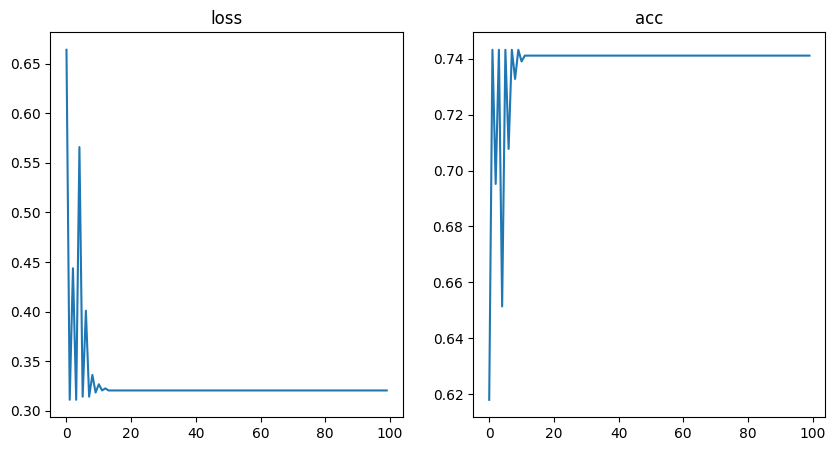

In [4]:
# plot loss and acc
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(loss_list)
axes[0].set_title(f'loss')
axes[1].plot(acc_list)
axes[1].set_title(f'acc')

plt.show()

#### Experiment3 by e5-mistral embedding (lr=1e-8)

In [2]:
# set hyper parameters
num_epoch = 100
thres = torch.tensor([700, 900])
embed_dim = 1024
num_layers = 4
batch_size = 20000  # adjust based on gpu memory
lr = 1e-8

# initializing SEAT
se_model = SEAT4(embed_dim, thres, num_layers)

optimizer = optim.SGD(se_model.parameters(), lr=lr)

loss_list = []
acc_list = []

# Preparing dataset
q_embs_train = torch.load("./squad_mxbai_q_embs/train.pt")
inf_embs_train = torch.load("./squad_mxbai_inf_embs/train.pt")
q_embs_test = torch.load("./squad_mxbai_q_embs/test.pt").to(device)
inf_embs_test = torch.load("./squad_mxbai_inf_embs/test.pt").to(device)

num_dataset_train = q_embs_train.shape[0]
num_dataset_test = q_embs_test.shape[0]

inf_one_zero_train = torch.eye(num_dataset_train).to(device)
inf_one_zero_test = torch.eye(num_dataset_test).to(device)

print(q_embs_train.shape, inf_embs_train.shape)

print(f"num_epoch:{num_epoch}")
print(f"num_dataset_train:{num_dataset_train}, num_dataset_test:{num_dataset_test}")


# scheduler
def set_lr(epoch, optimizer):
    global lr
    if epoch > 30:
        # Update learning rate to a new value
        lr = np.exp(-0.02) * lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer


# Learning and Evaluation
for epoch in range(num_epoch):

    optimizer = set_lr(epoch, optimizer)

    # train
    last_log_step = 0
    for i in range(0, num_dataset_train, batch_size):        
        # in order to avoid cuda oom
        batch_q_embs_train = q_embs_train[i:i+batch_size,:].clone().to(device)
        batch_inf_embs_train = inf_embs_train[i:i+batch_size,:].clone().to(device)

        #print("--------")
        #print(batch_q_embs_train, batch_inf_embs_train)
        #print(se_model(batch_q_embs_train, batch_inf_embs_train))
        #print("--------")
        
        se_model.step(batch_q_embs_train, batch_inf_embs_train, inf_one_zero_train[i:i+batch_size, i:i+batch_size], optimizer)
        
        del batch_q_embs_train, batch_inf_embs_train
        
        if i/num_dataset_train > last_log_step + 0.1:
            print(f"epoch{epoch} {100*(i+1)/num_dataset_train} % finished")
            last_log_step += 0.1

    # evaluation
    loss, acc, mean_num_out = se_model.evaluate(q_embs_test, inf_embs_test, inf_one_zero_test)
    loss_list.append(loss)
    acc_list.append(acc)
    
    print(f"epoch:{epoch+1},  lr:{lr},  eval_loss:{loss},  eval_acc:{acc},  mean_num_out:{mean_num_out}")

    #torch.save(se_model, f'./Experiment3/epoch{epoch+1}.pth')


torch.Size([20000, 1024]) torch.Size([20000, 1024])
num_epoch:100
num_dataset_train:20000, num_dataset_test:958
attention:tensor([[1022.9980,  401.5503,  401.5805,  ...,  450.6547,  397.3068,
          433.1317],
        [ 401.5503, 1022.9971,  564.6337,  ...,  571.2296,  591.1055,
          494.2925],
        [ 401.5805,  564.6337, 1022.9977,  ...,  483.2787,  469.7707,
          530.1523],
        ...,
        [ 450.6547,  571.2296,  483.2787,  ..., 1022.9976,  762.2194,
          617.2291],
        [ 450.3125,  527.1650,  455.2923,  ...,  813.1224,  816.4464,
          563.6431],
        [ 323.9927,  426.7025,  468.9184,  ...,  466.7423,  439.2528,
          670.7645]], device='cuda:0', grad_fn=<MmBackward0>)
epoch:1,  lr:1e-08,  eval_loss:0.31419625878334045,  eval_acc:0.743215024471283,  mean_num_out:1.0073069334030151
attention:tensor([[1022.9976,  407.7928,  407.8416,  ...,  456.8431,  403.7450,
          439.5484],
        [ 407.7928, 1022.9978,  569.6522,  ...,  576.3424,  595

In [3]:
torch.save(se_model, f'./rag1-2-experiment3.pth')

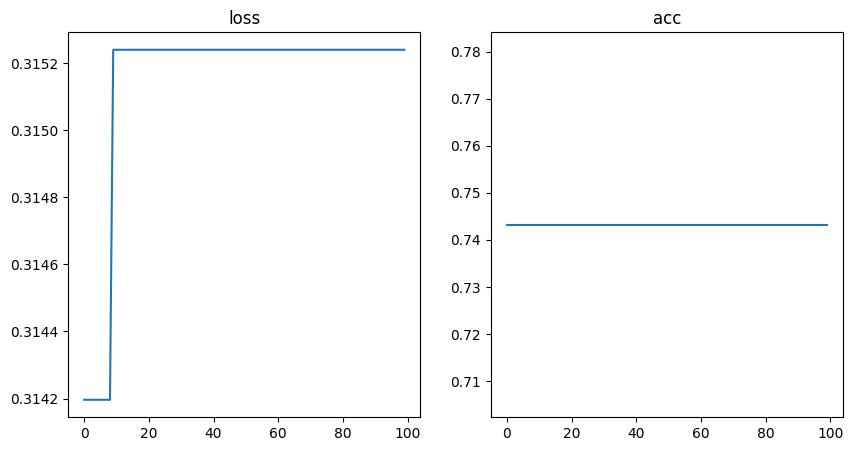

In [4]:
# plot loss and acc
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(loss_list)
axes[0].set_title(f'loss')
axes[1].plot(acc_list)
axes[1].set_title(f'acc')

plt.show()

In [43]:
# more precise evaluation looking inside the dataset
import random
import pandas as pd

random_int = random.randint(0, q_embs_test.shape[0])
select_df = pd.read_csv('select_df_squad.csv')

attention = se_model(q_embs_test[random_int:random_int+1,:,:], inf_embs_test)
predict_inf_one_zero = se_model.get_inf_one_zero(attention)
predict_ids = torch.nonzero(predict_inf_one_zero)
print("test question")
print(f"id:{select_df.iloc[q_embs_train.shape[0]+random_int]['id']}")
print(f"question:{select_df.iloc[q_embs_train.shape[0]+random_int]['question']}")
print(f"context:{select_df.iloc[q_embs_train.shape[0]+random_int]['context']}")
print()
print("taken informations")
for id in predict_ids:
    print(f"id:{select_df.iloc[q_embs_train.shape[0]+int(id[1])]['id']}")
    print(f"question:{select_df.iloc[q_embs_train.shape[0]+int(id[1])]['question']}")
    print(f"context:{select_df.iloc[q_embs_train.shape[0]+int(id[1])]['context']}")

test question
id:20847
question:Who was the viceregal Sakya regime overthrown by?
context:Wylie asserts that this type of censorship of the History of Ming distorts the true picture of the history of Sino-Tibetan relations, while the Ming court granted titles to various lamas regardless of their sectarian affiliations in an ongoing civil war in Tibet between competing Buddhist factions. Wylie argues that Ming titles of "King" granted indiscriminately to various Tibetan lamas or even their disciples should not be viewed as reappointments to earlier Yuan dynasty offices, since the viceregal Sakya regime established by the Mongols in Tibet was overthrown by the Phagmodru myriarchy before the Ming existed.

taken informations
id:20423
question:Who helped the Tibetan? 
context:When the Dzungar Mongols attempted to spread their territory from what is now Xinjiang into Tibet, the Kangxi Emperor (r. 1661–1722) responded to Tibetan pleas for aid with his own expedition to Tibet, occupying Lhasa

### Step4 - SEAT evaluation by textbook

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import json
import copy
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

device = "cuda" if torch.cuda.is_available else "cpu"

class LayerNorm(torch.nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = torch.nn.Parameter(torch.ones(features)).to(device)
        self.beta = torch.nn.Parameter(torch.zeros(features)).to(device)
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

# this class is only considering one layer
class SEAT4(nn.Module):
    
    def __init__(self, embed_dim, thres, num_layers):
        super(SEAT4, self).__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.thres = thres.float().to(device)

        self.q_projs = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_layers)]).to(device)
        self.k_projs = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_layers)]).to(device)
        self.v_projs = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_layers)]).to(device)

        self.up_projs = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_layers)]).to(device)
        self.down_projs = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_layers)]).to(device)

        self.layer_norms = nn.ModuleList([LayerNorm(embed_dim) for _ in range(num_layers)]).to(device)
        
        for layer in range(num_layers):
            self.q_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.q_projs[layer].bias.data.fill_(0.0).to(device)
            self.k_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.k_projs[layer].bias.data.fill_(0.0).to(device)
            self.v_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.v_projs[layer].bias.data.fill_(0.0).to(device)
            self.up_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.up_projs[layer].bias.data.fill_(0.0).to(device)
            self.down_projs[layer].weight.data = torch.eye(embed_dim).to(device)
            self.down_projs[layer].bias.data.fill_(0.0).to(device)
        
    # q_embs:(num_questions, embed_dim)
    # inf_embs:(num_contexts, embed_dim)
    def forward(self, q_embs, inf_embs):
        num_questions, num_contexts = q_embs.shape[0], inf_embs.shape[0]
        """
        q_embs = q_embs.unsqueeze(1)  #(num_questions, 1, embed_dim)
        inf_embs = inf_embs.expand(q_embs.shape[0], -1, -1)  #(num_questions, num_contexts, embed_dim)
        """
        embs = torch.cat((inf_embs, q_embs), dim = 0)  #(num_contexts + num_questions, embed_dim)
        
        for layer in range(self.num_layers):
            A = torch.matmul(self.q_projs[layer](embs), self.k_projs[layer](embs[:num_contexts,:]).transpose(-1,-2))  #(num_contexts + num_questions, num_contexts)
            #print("soft(A)")
            #print(F.softmax(A, dim=-1))
            #print("V sum")
            #print(torch.sum(self.v_projs[layer](embs[:num_contexts,:]), dim= 0))
            embs = torch.matmul(F.softmax(A*1000, dim=-1), self.v_projs[layer](embs[:num_contexts,:]))  #(num_contexts + num_questions, embed_dim)
            
            #embs = torch.matmul(A, self.v_projs[layer](embs[:num_contexts,:]))  #(num_contexts + num_questions, embed_dim)
            
            #print("embs1")
            #print(embs)
            embs = torch.relu(self.up_projs[layer](embs))
            embs = self.down_projs[layer](embs)  #(num_contexts + num_questions, embed_dim)

            embs = self.layer_norms[layer](embs)
            
            #print("embs2")
            #print(embs)

        #print("---------")
        attention = torch.matmul(embs[num_contexts:,:], embs[:num_contexts,:].transpose(-1,-2))  #(num_questions, num_contexts)
        #print(attention)
        return attention
        
    
    def step(self, q_embs, inf_embs, inf_one_zero, optimizer):
        
        self.train()
        mse_loss = nn.MSELoss()
        optimizer.zero_grad()
        #print(self(q_embs, inf_embs).shape, self.target(inf_one_zero).shape)
        loss = mse_loss(self(q_embs, inf_embs), self.target(inf_one_zero))
        loss.backward()
        optimizer.step()
        
        
    def target(self, inf_one_zero):
        return torch.where(inf_one_zero==1.0, 2*self.thres[1]-self.thres[0], 2*self.thres[0]-self.thres[1])
        

    def evaluate(self, q_embs, inf_embs, inf_one_zero):
        mse_loss = nn.MSELoss()
        attention = self(q_embs, inf_embs)
        print(f"attention:{attention}")  #(num_questions, num_information)
        predict_inf_one_zero = self.get_inf_one_zero(attention)
        #print(attention)
        
        loss = mse_loss(predict_inf_one_zero, inf_one_zero) * inf_one_zero.shape[0]
        
        acc_vec = torch.sum(torch.square(inf_one_zero - predict_inf_one_zero), dim=(0,))
        acc = torch.sum(torch.where(acc_vec == 0,1,0), dim=(0,)) / acc_vec.shape[0]

        mean_num_out = torch.sum(predict_inf_one_zero, dim=(0,1)) / predict_inf_one_zero.shape[0]

        return loss.detach().cpu(), acc.detach().cpu(), mean_num_out.detach().cpu()
        

    def get_inf_one_zero(self, attention):
        return torch.where(attention > self.thres[1], 1, 0)
        

    def get_path_one_zero(self, attention):
        return torch.where(attention > self.thres[0], 1, 0)

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
se_model = torch.load('rag1-2-experiment2.pth').to(device)
se_model

SEAT4(
  (q_projs): ModuleList(
    (0-3): 4 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (k_projs): ModuleList(
    (0-3): 4 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (v_projs): ModuleList(
    (0-3): 4 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (up_projs): ModuleList(
    (0-3): 4 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (down_projs): ModuleList(
    (0-3): 4 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (layer_norms): ModuleList(
    (0-3): 4 x LayerNorm()
  )
)

In [3]:
from sentence_transformers import SentenceTransformer, util
emb_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1").to(device)

In [13]:
import torch

questions = [
    "How to make a simplest gyrokinetic simulation?",
    "Give me 3 important equations for gyrokinetic vlasov simulation.",
]

q_embs = torch.tensor(emb_model.encode(questions)).to(device)
q_embs = q_embs.reshape(q_embs.shape[0], q_embs.shape[1])
q_embs.shape

torch.Size([2, 1024])

In [10]:
inf_embs = torch.load("CPS_split_embs.pt").to(device)
inf_embs.shape

torch.Size([178, 8, 1024])

In [11]:
inf_embs = inf_embs.reshape(inf_embs.shape[0]*inf_embs.shape[1], inf_embs.shape[2])
inf_embs.shape

torch.Size([1424, 1024])

In [14]:
relevance = se_model(q_embs, inf_embs)
relevance.shape

torch.Size([2, 1424])

In [16]:
inf_ids = torch.nonzero(relevance > se_model.thres[1])
infs = [[] for _ in range(relevance.shape[0])]

import json
json_file_path = "./sentences_list.json"
with open(json_file_path, 'r') as json_file:
    sentences_list = json.load(json_file)

for id in inf_ids:
    infs[id[0]].append(sentences_list[id[1]//8][id[1]%8])

for i in range(relevance.shape[0]):
    print(f"-----------informations for question{i} -----------")
    print(f"question : {questions[i]}")
    for j in range(len(infs[i])):
        print(f"--information {j}--")
        print(infs[i][j])
        print()
        

-----------informations for question0 -----------
question : How to make a simplest gyrokinetic simulation?
--information 0--
\\section*{Preface}
The book of Computational Plasma Science-Physics and Selected Simulation Examples is prepared for beginners and students about plasma physics in graduate and undergraduate courses in universities and colleges. The essence of plasma physics is introduced in a concise manner together with computational techniques, which are powerful tools to analyze plasmas.

Collective behavior is the characteristic of plasma. Plasma is ionized and consists of ions and electrons. Plasma is electrically quasi-neutral. Each neutral particle in neutral gas moves independently. However, each charged particle produces the longrange Coulomb force. Many charged particles move together, responding to electric and magnetic forces. The collective motion of plasma is remarkable and is different from that of the neutral gas.

The book presents the essential physics in pla

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,)
model = AutoModelForCausalLM.from_pretrained(model_id)